# INTRODUCCIÓN

El presente proyecto se enmarca en la competición de Kaggle *Santander Product Recommendation*, cuyo objetivo principal es predecir qué productos bancarios contratará un cliente en el mes siguiente. Para ello, se utiliza un conjunto de datos proporcionado por el banco Santander que contiene información mensual de clientes, incluyendo datos demográficos, socioeconómicos y un historial de productos contratados.

El desafío consiste en construir un modelo de recomendación personalizado capaz de identificar, para cada cliente, los nuevos productos que es probable que adquiera. Esta tarea implica abordar retos típicos del aprendizaje supervisado en un contexto de series temporales, como el desbalance de clases, la alta cardinalidad de ciertas variables categóricas y la necesidad de capturar la evolución temporal de los comportamientos de los clientes.

## Descripción de las variables

El conjunto de datos proporcionado por el Banco Santander incluye información mensual de clientes desde 2015, organizada de forma que cada fila representa el estado de un cliente en un mes determinado. Las variables se pueden agrupar en tres grandes bloques:

### 1. Datos de identificación y tiempo

- `ncodpers`: identificador único de cliente.
- `fecha_dato`: mes de referencia del registro (formato YYYY-MM-DD).
- `fecha_alta`: fecha en que el cliente se dio de alta en el banco.
- `ult_fec_cli_1t`: fecha de última baja del cliente (si procede).
- `indrel`, `indrel_1mes`: tipo de relación con el banco (activo, pasivo, etc.).

Estas variables permiten reconstruir la evolución temporal de cada cliente, algo esencial para capturar patrones de comportamiento a lo largo del tiempo.

### 2. Características personales y socioeconómicas

- `sexo`, `age`, `antiguedad`, `pais_residencia`, `nomprov`, `renta`, `segmento`, etc.

Este grupo de variables describe el perfil del cliente: edad, sexo, ubicación geográfica, nivel de ingresos estimado, y tipo de segmento asignado por el banco, lo cual puede influir en la probabilidad de adquirir ciertos productos.

### 3. Variables objetivo: productos bancarios

- `ind_ahor_fin_ult1`, `ind_dep_fin_ult1`, `ind_nomina_ult1`, ..., `ind_recibo_ult1`

Se trata de variables binarias (0 o 1) que indican si el cliente tenía contratado un determinado producto en ese mes. Algunos ejemplos de productos incluyen cuentas de ahorro, fondos de inversión, tarjetas de crédito o préstamos personales. El objetivo del modelo es predecir cuáles de estos productos nuevos contratará un cliente en el próximo mes.


# CARGA DE DATOS Y LIBRERÍAS

In [ ]:
# Importar librerías básicas para manipulación y análisis de datos
import pandas as pd
import numpy as np
import random

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesado
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Modelado
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Métricas de evaluación
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Configuración de visualizaciones y warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set(style="whitegrid")

import lightgbm as lgb

# Importamos el modelo KMeans desde sklearn
from sklearn.cluster import KMeans

# Importamos el modelo LightGBM y los callbacks necesarios
from lightgbm import LGBMClassifier
# Importamos el modelo LGBMClassifier y los callbacks desde lightgbm (compatible con versiones anteriores)
from lightgbm import LGBMClassifier, early_stopping, log_evaluation


In [ ]:
# Instalamos la librería de kaggle
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
folder_path = "/content/drive/My Drive/UNAV/Asignaturas/Machine Learning/Tareas/Tarea 5/datasets"
print(os.listdir(folder_path))

['train_ver2.csv', 'test_ver2.csv', 'sample_submission.csv']


## Carga de Datos (se comenta)

In [ ]:
# Definir nombres originales de los archivos
file_name_train = "train_ver2.csv"
file_name_test = "test_ver2.csv"

# Construir las rutas completas usando tu folder_path
file_path_train = os.path.join(folder_path, file_name_train)
file_path_test = os.path.join(folder_path, file_name_test)

# Contar el número total de líneas en el archivo (sin cargar el contenido)
with open(file_path_train) as f:
    total_lines = sum(1 for line in f)

# Definir el tamaño de la muestra (1 millón de filas)
sample_size = 500000

# Establecer una semilla para obtener la misma muestra en cada ejecución
random.seed(42)  # Puedes cambiar 42 por cualquier número fijo

# Calcular qué filas saltar (excepto la cabecera)
skip = sorted(random.sample(range(1, total_lines), total_lines - sample_size))

# Cargar solo las filas seleccionadas
train_original = pd.read_csv(file_path_train, skiprows=skip, low_memory=False)


# Cargamos el conjunto de prueba completo (es más pequeño)
test_original = pd.read_csv(file_path_test, low_memory=False)

In [ ]:
train = train_original.copy()
test = test_original.copy()

# ANÁLISIS EXPLORATORIO DE DATOS

## Descripción detallada de variables clave

Aunque muchas variables del conjunto de datos de Santander son autoexplicativas, algunas requieren una descripción más precisa por su codificación o naturaleza:

| Variable                     | Descripción |
|-----------------------------|-------------|
| **ncodpers**                | Identificador único del cliente. Permite agrupar los datos por individuo. |
| **fecha_dato**              | Fecha del registro mensual (formato AAAA-MM-DD). Es la dimensión temporal del dataset. |
| **fecha_alta**              | Fecha en la que el cliente se dio de alta en el banco. Útil para calcular antigüedad. |
| **ult_fec_cli_1t**          | Fecha de la última baja del cliente (si la hubo). Suele estar vacía. |
| **indrel**                  | Tipo de relación actual del cliente con el banco. Por ejemplo, cliente activo o pasivo. |
| **indrel_1mes**             | Relación del cliente con el banco en el último mes (puede ser categórica con valores como 1, 2, 3, 4, P). |
| **tiprel_1mes**             | Tipo de relación en el último mes:<br>• `A` = activo<br>• `I` = inactivo<br>• `P` = pendiente<br>• `R` = relación pasada |
| **indresi**                 | Indica si el cliente reside en España (`S`) o no (`N`). |
| **indext**                  | Indica si el cliente es extranjero (`S` o `N`). |
| **conyuemp**                | Indica si el cliente tiene cónyuge empleado en el banco (`S` o `N`). Con muchos valores nulos. |
| **canal_entrada**           | Canal utilizado para dar de alta al cliente (por ejemplo, `KHE`, `KAT`). Es una variable categórica. |
| **indfall**                 | Indica si el cliente ha fallecido (`S` o `N`). |
| **nomprov**                 | Provincia de residencia del cliente. Variable categórica con alta cardinalidad. |
| **segmento**                | Segmentación del cliente según perfil de ingresos y actividad:<br>• `01 - TOP`<br>• `02 - PARTICULARES`<br>• `03 - UNIVERSITARIO` |
| **renta**                   | Renta estimada del cliente. Contiene muchos valores nulos. |
| **age**                     | Edad del cliente. Puede venir como string, con valores extremos o faltantes. |
| **antiguedad**              | Antigüedad del cliente en meses. Puede requerir limpieza. |

> > Además, existen 24 variables binarias del tipo `ind_xxx_ult1` que indican si el cliente tenía contratado un producto bancario en ese mes. Estas variables son la base para construir el objetivo del modelo, que consiste en predecir cuáles de esos productos serán contratados el mes siguiente.



## Variables objetivo: productos bancarios

Cada una de las siguientes variables binarias indica si el cliente tenía contratado un producto específico en el mes correspondiente (valor 1) o no (valor 0). El objetivo del modelo es predecir cuáles de estos productos serán **nuevos** en el siguiente mes para cada cliente.

| Variable                  | Producto bancario |
|--------------------------|-------------------|
| **ind_ahor_fin_ult1**    | Cuenta de ahorro |
| **ind_aval_fin_ult1**    | Avales y garantías |
| **ind_cco_fin_ult1**     | Cuenta corriente |
| **ind_cder_fin_ult1**    | Certificados de depósito |
| **ind_cno_fin_ult1**     | Cuenta de nómina no remunerada |
| **ind_ctju_fin_ult1**    | Cuenta joven |
| **ind_ctma_fin_ult1**    | Cuenta para mayores |
| **ind_ctop_fin_ult1**    | Cuenta de pensiones |
| **ind_ctpp_fin_ult1**    | Plan de pensiones privado |
| **ind_deco_fin_ult1**    | Fondos de inversión |
| **ind_deme_fin_ult1**    | Depósitos a medio plazo |
| **ind_dela_fin_ult1**    | Depósitos a largo plazo |
| **ind_ecue_fin_ult1**    | Cuentas electrónicas |
| **ind_fond_fin_ult1**    | Fondos de inversión |
| **ind_hip_fin_ult1**     | Hipotecas |
| **ind_plan_fin_ult1**    | Planes de pensiones |
| **ind_pres_fin_ult1**    | Préstamos personales |
| **ind_reca_fin_ult1**    | Recaudaciones y domiciliaciones |
| **ind_tjcr_fin_ult1**    | Tarjetas de crédito |
| **ind_valo_fin_ult1**    | Valores (acciones, bonos) |
| **ind_viv_fin_ult1**     | Créditos para vivienda |
| **ind_nomina_ult1**      | Nómina domiciliada |
| **ind_nom_pens_ult1**    | Pensión domiciliada |
| **ind_recibo_ult1**      | Recibos domiciliados |

> Algunas de estas variables pueden estar altamente correlacionadas entre sí, o presentar una baja tasa de contratación. Por ello, es habitual hacer un análisis exploratorio previo y plantear estrategias para manejar el desbalance.

In [ ]:
train.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1050598,N,ES,H,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050676,N,ES,V,31,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050521,N,ES,H,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050500,N,ES,V,24,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050537,N,ES,H,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,1.0,1.0,0


## Variable objetivo -- número de contrataciones

In [ ]:
# Identificar columnas de productos (las que terminan en '_ult1')
product_cols = [col for col in train.columns if col.endswith('_ult1')]

# Crear nueva columna con el número total de productos contratados por fila
train['num_productos'] = train[product_cols].sum(axis=1)

## Tamaño del Dataset (muestra)

In [ ]:
## tamaño de train
print('train.shape -- ',train.shape)

## tamaño de test
print('test.shape -- ',test.shape)

train.shape --  (499999, 49)
test.shape --  (929615, 24)


## Columnas, Valores Nulos y Tipo de Dato

In [ ]:
# Usamos el orden original de columnas de train, que incluye todas las que queremos mostrar
ordered_columns = list(train.columns)

# Creamos el resumen respetando el orden original de train
summary = pd.DataFrame({'columna': ordered_columns})

# Añadimos el tipo de variable según aparece en train
summary['tipo'] = summary['columna'].map(lambda col: train[col].dtype)

# Añadimos conteo de nulos y porcentaje en train
summary['nulos_train'] = summary['columna'].map(lambda col: train[col].isnull().sum())
summary['porcentaje_train'] = summary['columna'].map(lambda col: train[col].isnull().mean() * 100)

# Añadimos conteo de nulos y porcentaje en test (solo si la columna existe en test, si no NaN)
summary['nulos_test'] = summary['columna'].map(lambda col: test[col].isnull().sum() if col in test.columns else np.nan)
summary['porcentaje_test'] = summary['columna'].map(lambda col: test[col].isnull().mean() * 100 if col in test.columns else np.nan)

# Redondeamos los porcentajes
summary['porcentaje_train'] = summary['porcentaje_train'].round(2)
summary['porcentaje_test'] = summary['porcentaje_test'].round(2)

# Mostramos el resumen
summary

,columna,tipo,nulos_train,porcentaje_train,nulos_test,porcentaje_test
0,fecha_dato,object,0,0.00,0.0,0.00
1,ncodpers,int64,0,0.00,0.0,0.00
2,ind_empleado,object,1078,0.22,0.0,0.00
3,pais_residencia,object,1078,0.22,0.0,0.00
4,sexo,object,1084,0.22,5.0,0.00
5,age,object,0,0.00,0.0,0.00
6,fecha_alta,object,1078,0.22,0.0,0.00
7,ind_nuevo,float64,1078,0.22,0.0,0.00
8,antiguedad,object,0,0.00,0.0,0.00
9,indrel,float64,1078,0.22,0.0,0.00


## Estadísticos Fundamentales

In [ ]:
# variables numéricas
train.describe()

,ncodpers,ind_nuevo,indrel,tipodom,cod_prov,ind_actividad_cliente,renta,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,...,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,num_productos
count,4.999990e+05,498921.000000,498921.000000,498921.0,496449.000000,498921.000000,3.973990e+05,499999.000000,499999.000000,499999.000000,...,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499377.000000,499377.000000,499999.000000,499999.000000
mean,8.353960e+05,0.059755,1.179531,1.0,26.573511,0.457976,1.345416e+05,0.000112,0.000030,0.655935,...,0.009178,0.002738,0.052694,0.044806,0.025788,0.003782,0.054422,0.059172,0.127610,1.462197
std,4.312605e+05,0.237033,4.190690,0.0,12.779241,0.498231,2.369664e+05,0.010582,0.005477,0.475063,...,0.095361,0.052254,0.223422,0.206878,0.158503,0.061382,0.226848,0.235946,0.333656,1.510491
min,1.588900e+04,0.000000,1.000000,1.0,1.000000,0.000000,1.202730e+03,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.542330e+05,0.000000,1.000000,1.0,15.000000,0.000000,6.880072e+04,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,9.323070e+05,0.000000,1.000000,1.0,28.000000,0.000000,1.020236e+05,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.199200e+06,0.000000,1.000000,1.0,35.000000,1.000000,1.560709e+05,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,1.553686e+06,1.000000,99.000000,1.0,52.000000,1.000000,2.889440e+07,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.000000


In [ ]:
# variables categóricas
train.describe(include=['object', 'category'])

,fecha_dato,ind_empleado,pais_residencia,sexo,age,fecha_alta,antiguedad,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,nomprov,segmento
count,499999,498921,498921,498915,499999,498921,499999,914,494376,494376,498921,498921,66,493052,498921,496449,492943
unique,17,5,97,2,118,6576,258,213,9,4,2,2,1,155,2,52,3
top,2016-05-28,N,ES,V,23,2014-07-28,12,2015-12-24,1.0,I,S,N,N,KHE,N,MADRID,02 - PARTICULARES
freq,34183,498593,496449,272248,28671,2075,8868,36,333826,267456,496449,475243,66,148716,497648,161181,291617


## Valores Nulos y tipo de dato

In [ ]:
# Calcular porcentaje de nulos en train
porcentaje_nulos_train = (train.isna().sum() / len(train) * 100).round(2).astype(str) + '%'

# Calcular porcentaje de nulos en test
porcentaje_nulos_test = (test.isna().sum() / len(test) * 100).round(2).astype(str) + '%'

# Crear resumen para train con porcentaje incluido
resumen_train = pd.DataFrame({
    'nulos_train': train.isna().sum().astype(str) + ' (' + porcentaje_nulos_train + ')',
    'tipo_dato_train': train.dtypes,
    'valores_unicos_train': train.nunique(dropna=False)
})

# Crear resumen para test con porcentaje incluido
resumen_test = pd.DataFrame({
    'nulos_test': test.isna().sum().astype(str) + ' (' + porcentaje_nulos_test + ')',
    'tipo_dato_test': test.dtypes,
    'valores_unicos_test': test.nunique(dropna=False)
})

# Unir ambos resúmenes por el índice (nombre de columna)
resumen_completo = pd.concat([resumen_train, resumen_test], axis=1)

# Eliminar columnas que no están en test
resumen_completo = resumen_completo[~resumen_completo['tipo_dato_test'].isna()]

# Añadir columna para indicar si los tipos de dato difieren entre train y test
resumen_completo['tipo_dato_difiere'] = resumen_completo['tipo_dato_train'] != resumen_completo['tipo_dato_test']

# Función auxiliar para extraer número de nulos de la cadena con porcentaje
def extraer_nulos(cadena):
    return int(cadena.split(' ')[0])

# Filtrar filas relevantes (con nulos o tipos distintos)
# Corregir el error de ambigüedad con paréntesis adicionales alrededor de cada condición
filtro = (
    (resumen_completo['nulos_train'].apply(extraer_nulos) > 0) |
    (resumen_completo['nulos_test'].apply(extraer_nulos) > 0) |
    (resumen_completo['tipo_dato_difiere'])
)

# Mostrar resumen ordenado por número de nulos en test
display(resumen_completo[filtro].sort_values(by='nulos_test', key=lambda x: x.apply(extraer_nulos), ascending=False))

# Mostrar el número de filas del resumen filtrado
print("Número de filas con nulos o tipo distinto:", resumen_completo[filtro].shape[0])

,nulos_train,tipo_dato_train,valores_unicos_train,nulos_test,tipo_dato_test,valores_unicos_test,tipo_dato_difiere
conyuemp,499933 (99.99%),object,2,929511 (99.99%),object,3.0,False
ult_fec_cli_1t,499085 (99.82%),object,214,927932 (99.82%),object,22.0,False
cod_prov,3550 (0.71%),float64,53,3996 (0.43%),float64,53.0,False
nomprov,3550 (0.71%),object,53,3996 (0.43%),object,53.0,False
segmento,7056 (1.41%),object,4,2248 (0.24%),object,4.0,False
canal_entrada,6947 (1.39%),object,156,2081 (0.22%),object,163.0,False
tiprel_1mes,5623 (1.12%),object,5,23 (0.0%),object,4.0,False
indrel_1mes,5623 (1.12%),object,10,23 (0.0%),float64,3.0,True
sexo,1084 (0.22%),object,3,5 (0.0%),object,3.0,False
ind_nuevo,1078 (0.22%),float64,3,0 (0.0%),int64,2.0,True


Número de filas con nulos o tipo distinto: 22


# LIMPIEZA DE DATOS

In [ ]:
# Calcular porcentaje de nulos en train
porcentaje_nulos_train = (train.isna().sum() / len(train) * 100).round(2).astype(str) + '%'

# Calcular porcentaje de nulos en test
porcentaje_nulos_test = (test.isna().sum() / len(test) * 100).round(2).astype(str) + '%'

# Crear resumen para train con porcentaje incluido
resumen_train = pd.DataFrame({
    'nulos_train': train.isna().sum().astype(str) + ' (' + porcentaje_nulos_train + ')',
    'tipo_dato_train': train.dtypes,
    'valores_unicos_train': train.nunique(dropna=False)
})

# Crear resumen para test con porcentaje incluido
resumen_test = pd.DataFrame({
    'nulos_test': test.isna().sum().astype(str) + ' (' + porcentaje_nulos_test + ')',
    'tipo_dato_test': test.dtypes,
    'valores_unicos_test': test.nunique(dropna=False)
})

# Unir ambos resúmenes por el índice (nombre de columna)
resumen_completo = pd.concat([resumen_train, resumen_test], axis=1)

# Eliminar columnas que no están en test
resumen_completo = resumen_completo[~resumen_completo['tipo_dato_test'].isna()]

# Añadir columna para indicar si los tipos de dato difieren entre train y test
resumen_completo['tipo_dato_difiere'] = resumen_completo['tipo_dato_train'] != resumen_completo['tipo_dato_test']

# Función auxiliar para extraer número de nulos de la cadena con porcentaje
def extraer_nulos(cadena):
    return int(cadena.split(' ')[0])

# Filtrar filas relevantes (con nulos o tipos distintos)
# Corregir el error de ambigüedad con paréntesis adicionales alrededor de cada condición
filtro = (
    (resumen_completo['nulos_train'].apply(extraer_nulos) > 0) |
    (resumen_completo['nulos_test'].apply(extraer_nulos) > 0) |
    (resumen_completo['tipo_dato_difiere'])
)

# Mostrar resumen ordenado por número de nulos en test
display(resumen_completo[filtro].sort_values(by='nulos_test', key=lambda x: x.apply(extraer_nulos), ascending=False))

# Mostrar el número de filas del resumen filtrado
print("Número de filas con nulos o tipo distinto:", resumen_completo[filtro].shape[0])

,nulos_train,tipo_dato_train,valores_unicos_train,nulos_test,tipo_dato_test,valores_unicos_test,tipo_dato_difiere
conyuemp,499933 (99.99%),object,2,929511 (99.99%),object,3.0,False
ult_fec_cli_1t,499085 (99.82%),object,214,927932 (99.82%),object,22.0,False
cod_prov,3550 (0.71%),float64,53,3996 (0.43%),float64,53.0,False
nomprov,3550 (0.71%),object,53,3996 (0.43%),object,53.0,False
segmento,7056 (1.41%),object,4,2248 (0.24%),object,4.0,False
canal_entrada,6947 (1.39%),object,156,2081 (0.22%),object,163.0,False
tiprel_1mes,5623 (1.12%),object,5,23 (0.0%),object,4.0,False
indrel_1mes,5623 (1.12%),object,10,23 (0.0%),float64,3.0,True
sexo,1084 (0.22%),object,3,5 (0.0%),object,3.0,False
ind_nuevo,1078 (0.22%),float64,3,0 (0.0%),int64,2.0,True


Número de filas con nulos o tipo distinto: 22


Se eliminan las filas que contengan valores nulos en 'train' pero no en 'test'

## Eliminación de filas con valores nulos

Se eliminan las filas de las variables que tienen valores nulos en train pero no en test

In [ ]:
# Lista de columnas con nulos en train pero sin nulos en test (usando número de nulos)
cols_train_nulos = resumen_completo[
    (resumen_completo['nulos_train'].apply(extraer_nulos) > 0) &
    (resumen_completo['nulos_test'].apply(extraer_nulos) == 0)
].index.tolist()

# Eliminar filas de train que tengan nulos en esas columnas
train = train.dropna(subset=cols_train_nulos)

Se muestran las columnas que aún tienen valores nulos en train y test

In [ ]:
# Calcular porcentaje de nulos en train
porcentaje_nulos_train = (train.isna().sum() / len(train) * 100).round(2).astype(str) + '%'

# Calcular porcentaje de nulos en test
porcentaje_nulos_test = (test.isna().sum() / len(test) * 100).round(2).astype(str) + '%'

# Crear resumen para train con porcentaje incluido
resumen_train = pd.DataFrame({
    'nulos_train': train.isna().sum().astype(str) + ' (' + porcentaje_nulos_train + ')',
    'tipo_dato_train': train.dtypes,
    'valores_unicos_train': train.nunique(dropna=False)
})

# Crear resumen para test con porcentaje incluido
resumen_test = pd.DataFrame({
    'nulos_test': test.isna().sum().astype(str) + ' (' + porcentaje_nulos_test + ')',
    'tipo_dato_test': test.dtypes,
    'valores_unicos_test': test.nunique(dropna=False)
})

# Unir ambos resúmenes por el índice (nombre de columna)
resumen_completo = pd.concat([resumen_train, resumen_test], axis=1)

# Eliminar columnas que no están en test
resumen_completo = resumen_completo[~resumen_completo['tipo_dato_test'].isna()]

# Añadir columna para indicar si los tipos de dato difieren entre train y test
resumen_completo['tipo_dato_difiere'] = resumen_completo['tipo_dato_train'] != resumen_completo['tipo_dato_test']

# Función auxiliar para extraer número de nulos de la cadena con porcentaje
def extraer_nulos(cadena):
    return int(cadena.split(' ')[0])

# Filtrar filas relevantes (con nulos o tipos distintos)
# Corregir el error de ambigüedad con paréntesis adicionales alrededor de cada condición
filtro = (
    (resumen_completo['nulos_train'].apply(extraer_nulos) > 0) |
    (resumen_completo['nulos_test'].apply(extraer_nulos) > 0) |
    (resumen_completo['tipo_dato_difiere'])
)

# Mostrar resumen ordenado por número de nulos en test
display(resumen_completo[filtro].sort_values(by='nulos_test', key=lambda x: x.apply(extraer_nulos), ascending=False))

# Mostrar el número de filas del resumen filtrado
print("Número de filas con nulos o tipo distinto:", resumen_completo[filtro].shape[0])

,nulos_train,tipo_dato_train,valores_unicos_train,nulos_test,tipo_dato_test,valores_unicos_test,tipo_dato_difiere
conyuemp,397339 (99.98%),object,2,929511 (99.99%),object,3.0,False
ult_fec_cli_1t,397085 (99.92%),object,137,927932 (99.82%),object,22.0,False
cod_prov,12 (0.0%),float64,53,3996 (0.43%),float64,53.0,False
nomprov,12 (0.0%),object,53,3996 (0.43%),object,53.0,False
segmento,2063 (0.52%),object,4,2248 (0.24%),object,4.0,False
canal_entrada,1997 (0.5%),object,152,2081 (0.22%),object,163.0,False
tiprel_1mes,1182 (0.3%),object,5,23 (0.0%),object,4.0,False
indrel_1mes,1182 (0.3%),object,9,23 (0.0%),float64,3.0,True
sexo,4 (0.0%),object,3,5 (0.0%),object,3.0,False
age,0 (0.0%),object,117,0 (0.0%),int64,118.0,True


Número de filas con nulos o tipo distinto: 16


In [ ]:
# Contar el número de columnas con tipo de dato distinto entre train y test
num_dato_difiere = resumen_completo[filtro]['tipo_dato_difiere'].sum()

# Mostrar el resultado
print("Número de columnas cuyo tipo de dato difiere:", num_dato_difiere)

Número de columnas cuyo tipo de dato difiere: 8


## Valores Nulos

In [ ]:
# Calcular número y porcentaje de nulos por columna en train
nulos_train = train.isna().sum()
porc_nulos_train = (nulos_train / len(train) * 100).round(2)

# Calcular número y porcentaje de nulos por columna en test
nulos_test = test.isna().sum()
porc_nulos_test = (nulos_test / len(test) * 100).round(2)

# Crear DataFrame solo con número y porcentaje de nulos en train
nulos_train_df = pd.DataFrame({
    'nulos_train': nulos_train,
    'porc_nulos_train': porc_nulos_train
})

# Crear DataFrame solo con número y porcentaje de nulos en test
nulos_test_df = pd.DataFrame({
    'nulos_test': nulos_test,
    'porc_nulos_test': porc_nulos_test
})

# Unir ambos resúmenes
resumen_nulos = pd.concat([nulos_train_df, nulos_test_df], axis=1)

# Filtrar filas con algún nulo
resumen_nulos = resumen_nulos[(resumen_nulos['nulos_train'] > 0) | (resumen_nulos['nulos_test'] > 0)]

# Mostrar resumen ordenado por porcentaje de nulos en test
display(resumen_nulos.sort_values(by='porc_nulos_test', ascending=False))

# Mostrar el número de filas del resumen filtrado
print("Número de filas con nulos o tipo distinto:", resumen_nulos.shape[0])

,nulos_train,porc_nulos_train,nulos_test,porc_nulos_test
conyuemp,397339,99.98,929511.0,99.99
ult_fec_cli_1t,397085,99.92,927932.0,99.82
nomprov,12,0.00,3996.0,0.43
cod_prov,12,0.00,3996.0,0.43
segmento,2063,0.52,2248.0,0.24
canal_entrada,1997,0.50,2081.0,0.22
sexo,4,0.00,5.0,0.00
tiprel_1mes,1182,0.30,23.0,0.00
indrel_1mes,1182,0.30,23.0,0.00
ind_nomina_ult1,10,0.00,NaN,NaN


Número de filas con nulos o tipo distinto: 11


### conyuemp

In [ ]:
train.drop(columns='conyuemp', inplace=True)
test.drop(columns='conyuemp', inplace=True)

### ult_fec_cli_1t

In [ ]:
# Porcentaje y número de nulos de 'ult_fec_cli_1t' en train
print("Nº de nulos en train:", train['ult_fec_cli_1t'].isnull().sum())
print("% de nulos en train:", round(train['ult_fec_cli_1t'].isnull().mean() * 100, 2), "%")

# Porcentaje y número de nulos de 'ult_fec_cli_1t' en test
print("Nº de nulos en test:", test['ult_fec_cli_1t'].isnull().sum())
print("% de nulos en test:", round(test['ult_fec_cli_1t'].isnull().mean() * 100, 2), "%")

Nº de nulos en train: 397085
% de nulos en train: 99.92 %
Nº de nulos en test: 927932
% de nulos en test: 99.82 %


In [ ]:
# Tipo de variable y valores únicos de 'ult_fec_cli_1t' en train
print("train['ult_fec_cli_1t'] →", train['ult_fec_cli_1t'].dtype)
print("Valores únicos en train:", train['ult_fec_cli_1t'].unique())

# Tipo de variable y valores únicos de 'ult_fec_cli_1t' en test
print("test['ult_fec_cli_1t'] →", test['ult_fec_cli_1t'].dtype)
print("Valores únicos en test:", test['ult_fec_cli_1t'].unique())

train['ult_fec_cli_1t'] → object
Valores únicos en train: [nan '2015-07-14' '2015-07-30' '2015-07-09' '2015-09-22' '2015-09-18'
 '2015-09-21' '2015-09-25' '2015-09-28' '2015-09-24' '2015-09-23'
 '2015-09-29' '2015-10-09' '2015-10-21' '2015-10-15' '2015-10-07'
 '2015-10-14' '2015-10-26' '2015-10-23' '2015-10-13' '2015-10-01'
 '2015-10-06' '2015-10-19' '2015-10-27' '2015-10-02' '2015-10-05'
 '2015-10-08' '2015-10-20' '2015-10-22' '2015-10-28' '2015-11-13'
 '2015-11-25' '2015-11-16' '2015-11-17' '2015-11-18' '2015-11-10'
 '2015-11-03' '2015-11-05' '2015-11-11' '2015-11-23' '2015-11-24'
 '2015-11-06' '2015-11-02' '2015-11-27' '2015-11-19' '2015-11-20'
 '2015-12-28' '2015-12-17' '2015-12-14' '2015-12-21' '2015-12-15'
 '2015-12-16' '2015-12-04' '2015-12-09' '2015-12-01' '2015-12-18'
 '2015-12-29' '2015-12-24' '2015-12-10' '2015-12-02' '2015-12-07'
 '2015-12-11' '2016-01-22' '2016-01-20' '2016-01-08' '2016-01-13'
 '2016-01-28' '2016-01-26' '2016-01-07' '2016-01-05' '2016-01-18'
 '2016-01-12' 

In [ ]:
train['tiene_fecha_cli_1t'] = train['ult_fec_cli_1t'].notna().astype(int)
test['tiene_fecha_cli_1t'] = test['ult_fec_cli_1t'].notna().astype(int)

train.drop(columns='ult_fec_cli_1t', inplace=True)
test.drop(columns='ult_fec_cli_1t', inplace=True)

In [ ]:
# Tipo de variable y valores únicos de 'ult_fec_cli_1t' en train
print("train['tiene_fecha_cli_1t'] →", train['tiene_fecha_cli_1t'].dtype)
print("Valores únicos en train:", train['tiene_fecha_cli_1t'].unique())

# Tipo de variable y valores únicos de 'ult_fec_cli_1t' en test
print("test['tiene_fecha_cli_1t'] →", test['tiene_fecha_cli_1t'].dtype)
print("Valores únicos en test:", test['tiene_fecha_cli_1t'].unique())

train['tiene_fecha_cli_1t'] → int64
Valores únicos en train: [0 1]
test['tiene_fecha_cli_1t'] → int64
Valores únicos en test: [0 1]


### segmento

In [ ]:
# Porcentaje y número de nulos de 'segmento' en train
print("Nº de nulos en train:", train['segmento'].isnull().sum())
print("% de nulos en train:", round(train['segmento'].isnull().mean() * 100, 2), "%")

# Porcentaje y número de nulos de 'segmento' en test
print("Nº de nulos en test:", test['segmento'].isnull().sum())
print("% de nulos en test:", round(test['segmento'].isnull().mean() * 100, 2), "%")

Nº de nulos en train: 2063
% de nulos en train: 0.52 %
Nº de nulos en test: 2248
% de nulos en test: 0.24 %


In [ ]:
# Tipo de variable y valores únicos de 'age' en train
print("train['segmento'] →", train['segmento'].dtype)
print("Valores únicos en train:", train['segmento'].unique())

# Tipo de variable y valores únicos de 'age' en test
print("test['segmento'] →", test['segmento'].dtype)
print("Valores únicos en test:", test['segmento'].unique())

train['segmento'] → object
Valores únicos en train: ['03 - UNIVERSITARIO' '02 - PARTICULARES' '01 - TOP' nan]
test['segmento'] → object
Valores únicos en test: ['01 - TOP' '02 - PARTICULARES' '03 - UNIVERSITARIO' nan]


In [ ]:
train['segmento'] = train['segmento'].fillna('UNKNOWN')
test['segmento'] = test['segmento'].fillna('UNKNOWN')

# Diccionario de codificación ordenada de segmento
map_segmento = {
    '01 - TOP': 3,
    '02 - PARTICULARES': 2,
    '03 - UNIVERSITARIO': 1,
    'UNKNOWN': 0
}

# Aplicar codificación ordinal
train['segmento_cod'] = train['segmento'].map(map_segmento)
test['segmento_cod'] = test['segmento'].map(map_segmento)

# Eliminar la columna original 'segmento'
train.drop(columns='segmento', inplace=True)
test.drop(columns='segmento', inplace=True)

In [ ]:
# Tipo de variable y valores únicos de 'age' en train
print("train['segmento_cod'] →", train['segmento_cod'].dtype)
print("Valores únicos en train:", train['segmento_cod'].unique())

# Tipo de variable y valores únicos de 'age' en test
print("test['segmento_cod'] →", test['segmento_cod'].dtype)
print("Valores únicos en test:", test['segmento_cod'].unique())

train['segmento_cod'] → int64
Valores únicos en train: [1 2 3 0]
test['segmento_cod'] → int64
Valores únicos en test: [3 2 1 0]


### canal_entrada

In [ ]:
# Porcentaje y número de nulos de 'canal_entrada' en train
print("Nº de nulos en train:", train['canal_entrada'].isnull().sum())
print("% de nulos en train:", round(train['canal_entrada'].isnull().mean() * 100, 2), "%")

# Porcentaje y número de nulos de 'canal_entrada' en test
print("Nº de nulos en test:", test['canal_entrada'].isnull().sum())
print("% de nulos en test:", round(test['canal_entrada'].isnull().mean() * 100, 2), "%")

Nº de nulos en train: 1997
% de nulos en train: 0.5 %
Nº de nulos en test: 2081
% de nulos en test: 0.22 %


In [ ]:
# Tipo de variable y valores únicos de 'canal_entrada' en train
print("train['canal_entrada'] →", train['canal_entrada'].dtype)
print("Valores únicos en train:", train['canal_entrada'].unique())

# Tipo de variable y valores únicos de 'canal_entrada' en test
print("test['canal_entrada'] →", test['canal_entrada'].dtype)
print("Valores únicos en test:", test['canal_entrada'].unique())

train['canal_entrada'] → object
Valores únicos en train: ['KHE' 'KFC' 'KHD' 'KAT' 'KFA' 'KAZ' 'KHC' 'KHN' 'KHK' 'KAB' 'KAR' 'KFD'
 'KFP' 'RED' 'KAH' 'KAE' 'KFS' 'KAG' 'KFG' 'KAQ' 'KGV' 'KGX' 'KFJ' 'KFU'
 'KCC' 'KAJ' 'KAA' 'KFF' 'KHF' 'KHL' 'KBG' 'KCG' 'KBZ' 'KDE' 'KAY' 'KBO'
 'KBU' 'KDR' 'KBQ' '007' 'KCB' 'KDT' 'KCK' 'KAD' 'KCD' 'KCI' 'KAP' 'KEJ'
 'KBH' 'KCL' 'KEH' 'KES' 'KAS' 'KCV' 'KDP' 'KDO' 'KBV' 'KBR' 'KBW' 'KCM'
 'KDX' 'KBE' 'KDC' 'KBL' 'KAM' 'KCA' 'KAF' 'KDD' 'KDG' 'KDU' 'KDF' 'KEY'
 'KDM' 'KEW' 'KCH' 'KFT' 'KEG' 'KEZ' 'KAV' '013' 'KAW' 'KED' 'KAL' 'KAO'
 'KEN' 'KBF' 'KFN' 'KFK' 'KGW' 'KAI' 'KFH' 'KCU' 'KAK' 'KAN' 'KCQ' 'KEK'
 nan 'KBJ' 'KBB' 'KEL' 'KBS' 'K00' 'KFB' 'KDN' 'KFM' 'KFI' '004' 'KAU'
 'KDS' 'KDQ' 'KCF' 'KEI' 'KCN' 'KAC' 'KEO' 'KEM' 'KCJ' 'KGY' 'KDA' 'KBD'
 'KEV' 'KHO' 'KHM' 'KBM' 'KEA' 'KBY' 'KCP' 'KEU' 'KGC' 'KEC' 'KCS' 'KBX'
 'KCE' 'KDV' 'KCO' 'KEF' 'KEB' 'KCR' 'KHQ' 'KHP' 'KEQ' 'KDY' 'KCX' 'KFV'
 'KCT' 'KFE' 'KBP' 'KFL' 'KDH' 'KDZ' 'KBN' 'KHA']
test['canal_entrada

In [ ]:
# Imputar valores nulos en 'canal_entrada' con 'UNKNOWN'
train['canal_entrada'] = train['canal_entrada'].fillna('UNKNOWN')
test['canal_entrada'] = test['canal_entrada'].fillna('UNKNOWN')

In [ ]:
# Calcular frecuencia relativa de cada canal en train
canal_freq = train['canal_entrada'].value_counts(normalize=True)

# Definir como frecuentes los canales con más del 0.5% de los clientes
canales_frecuentes = canal_freq[canal_freq > 0.005].index

In [ ]:
# Agrupar los canales poco frecuentes bajo la categoría 'OTROS'
train['canal_entrada'] = train['canal_entrada'].apply(lambda x: x if x in canales_frecuentes else 'OTROS')
test['canal_entrada'] = test['canal_entrada'].apply(lambda x: x if x in canales_frecuentes else 'OTROS')

In [ ]:
# Tipo de variable y valores únicos de 'canal_entrada' en train
print("train['canal_entrada'] →", train['canal_entrada'].dtype)
print("Valores únicos en train:", train['canal_entrada'].unique())

# Tipo de variable y valores únicos de 'canal_entrada' en test
print("test['canal_entrada'] →", test['canal_entrada'].dtype)
print("Valores únicos en test:", test['canal_entrada'].unique())

train['canal_entrada'] → object
Valores únicos en train: ['KHE' 'KFC' 'KHD' 'KAT' 'KFA' 'OTROS' 'KHN' 'KHK' 'KAB' 'RED' 'KAG' 'KAA'
 'KAY' 'KAS' 'UNKNOWN' 'KHM' 'KHQ']
test['canal_entrada'] → object
Valores únicos en test: ['KAT' 'KHE' 'KFC' 'KHN' 'KFA' 'KHM' 'OTROS' 'RED' 'KHQ' 'KHK' 'KHD'
 'UNKNOWN' 'KAB' 'KAG' 'KAY' 'KAA' 'KAS']


In [ ]:
# Celda 1: Aplicar Label Encoding a las columnas categóricas seleccionadas
from sklearn.preprocessing import LabelEncoder

# Lista de columnas categóricas a codificar
columnas_categoricas = ['canal_entrada']

# Aplicar Label Encoding en train y test
for col in columnas_categoricas:
    le = LabelEncoder()
    train[col + '_le'] = le.fit_transform(train[col])
    test[col + '_le'] = le.transform(test[col])

In [ ]:
# Celda 2: Convertir columnas codificadas a tipo category (útil para LightGBM)
for col in columnas_categoricas:
    train[col + 'cat'] = train[col + '_le'].astype('category')
    test[col + 'cat'] = test[col + '_le'].astype('category')

In [ ]:
train.drop(columns=col, inplace=True)
test.drop(columns=col, inplace=True)

### indrel

Indica el **tipo de relación principal del cliente con el banco**.  
Valores típicos:
- `"1"` → Cliente activo  
- `"99"` → Cliente pasivo o ex-cliente  

Suele ser **estable en el tiempo** y menos informativa que `indrel_1mes`.

In [ ]:
# Mostramos la cantidad y el porcentaje de valores nulos en 'indrel' para train
print("Train - indrel:")
print(train['indrel'].isna().sum(), "nulos")
print(round(train['indrel'].isna().mean() * 100, 2), "% nulos")

# Mostramos la cantidad y el porcentaje de valores nulos en 'indrel' para test
print("\nTest - indrel:")
print(test['indrel'].isna().sum(), "nulos")
print(round(test['indrel'].isna().mean() * 100, 2), "% nulos")

Train - indrel:
0 nulos
0.0 % nulos

Test - indrel:
0 nulos
0.0 % nulos


In [ ]:
# Tipo de variable y valores únicos de 'indrel' en train
print("train['indrel'] →", train['indrel'].dtype)
print("Valores únicos en train:", train['indrel'].unique())

# Tipo de variable y valores únicos de 'indrel' en test
print("test['indrel'] →", test['indrel'].dtype)
print("Valores únicos en test:", test['indrel'].unique())

train['indrel'] → float64
Valores únicos en train: [ 1. 99.]
test['indrel'] → int64
Valores únicos en test: [ 1 99]


In [ ]:
# Convertir 'indrel' de float a int en train
train['indrel'] = train['indrel'].astype('Int64')

# Convertir 'indrel' de float a int en test
test['indrel'] = test['indrel'].astype('Int64')

# Convertir a variable binaria (1 si es 1, 0 si es 99)
train['indrel'] = (train['indrel'] == 1).astype('int8')
test['indrel'] = (test['indrel'] == 1).astype('int8')

### cod_prov

In [ ]:
# Porcentaje y número de nulos de 'cod_prov' en train
print("Nº de nulos en train:", train['cod_prov'].isnull().sum())
print("% de nulos en train:", round(train['cod_prov'].isnull().mean() * 100, 2), "%")

# Porcentaje y número de nulos de 'cod_prov' en test
print("Nº de nulos en test:", test['cod_prov'].isnull().sum())
print("% de nulos en test:", round(test['cod_prov'].isnull().mean() * 100, 2), "%")

Nº de nulos en train: 12
% de nulos en train: 0.0 %
Nº de nulos en test: 3996
% de nulos en test: 0.43 %


In [ ]:
# Filas donde solo uno de los dos campos es nulo en train
nulos_desiguales_train = train[
    train['nomprov'].isnull() != train['cod_prov'].isnull()
][['nomprov', 'cod_prov']]

# Filas donde solo uno de los dos campos es nulo en test
nulos_desiguales_test = test[
    test['nomprov'].isnull() != test['cod_prov'].isnull()
][['nomprov', 'cod_prov']]

# Añadir columna para identificar el origen
nulos_desiguales_train['dataset'] = 'train'
nulos_desiguales_test['dataset'] = 'test'

# Concatenar resultados
nulos_desiguales = pd.concat([nulos_desiguales_train, nulos_desiguales_test])

# Reordenar columnas
nulos_desiguales = nulos_desiguales[['dataset', 'nomprov', 'cod_prov']]

# Mostrar resultado
print(nulos_desiguales)

Empty DataFrame
Columns: [dataset, nomprov, cod_prov]
Index: []


In [ ]:
# Tipo de variable y valores únicos de 'cod_prov' en train
print("train['cod_prov'] →", train['cod_prov'].dtype)
print("Valores únicos en train:", train['cod_prov'].unique())

# Tipo de variable y valores únicos de 'cod_prov' en test
print("test['cod_prov'] →", test['cod_prov'].dtype)
print("Valores únicos en test:", test['cod_prov'].unique())

train['cod_prov'] → float64
Valores únicos en train: [45. 32. 13. 50. 28. 39. 37. 46. 10.  3.  8. 24. 36.  9. 14. 43. 25. 12.
 22. 34. 11. 29. 26. 40. 38. 30. 41. 21. 15. 33.  6. 47. 42.  2. 17. 27.
 35.  7. 18. 44. 49.  4. 16. 23. 19.  5. 52. 51. nan 31. 48.  1. 20.]
test['cod_prov'] → float64
Valores únicos en test: [28.  3. 15.  8.  7. 35. 45. 14. 30. 16. 29. 23. 11. 41. 46. 12.  6. 32.
 17. 18. 13. 39. 10. 52. 33. 50. 22. 44. 27.  9. 31. 47. 37. 26. 25. 24.
 20. 43. 42.  2. 40. 21. 36.  4.  5. 34. 19.  1. 49. 38. nan 48. 51.]


In [ ]:
# Imputar valores nulos en 'cod_prov' con -1
train['cod_prov'] = train['cod_prov'].fillna(-1)
test['cod_prov'] = test['cod_prov'].fillna(-1)

# Convertir 'cod_prov' a entero
train['cod_prov'] = train['cod_prov'].astype(int)
test['cod_prov'] = test['cod_prov'].astype(int)

# Eliminar la columna redundante 'nomprov'
train.drop(columns='nomprov', inplace=True)
test.drop(columns='nomprov', inplace=True)

### Comprobación de valores nulos

In [ ]:
# Calcular número de nulos en train y test
nulos_train = train.isna().sum()
nulos_test = test.isna().sum()

# Crear resumen para train
resumen_train = pd.DataFrame({
    'nulos_train': nulos_train,
    'tipo_dato_train': train.dtypes,
    'valores_unicos_train': train.nunique(dropna=False)
})

# Crear resumen para test
resumen_test = pd.DataFrame({
    'nulos_test': nulos_test,
    'tipo_dato_test': test.dtypes,
    'valores_unicos_test': test.nunique(dropna=False)
})

# Unir ambos resúmenes por el índice (nombre de columna)
resumen_completo = pd.concat([resumen_train, resumen_test], axis=1)

# Filtrar columnas que existen en test (tipo_dato_test no es NaN)
resumen_completo = resumen_completo[~resumen_completo['tipo_dato_test'].isna()]

# Ordenar por número de nulos en train
resumen_completo = resumen_completo.sort_values(by='nulos_train', ascending=False)

# Mostrar solo columnas con algún nulo en train o test
display(resumen_completo[(resumen_completo['nulos_train'] > 0) | (resumen_completo['nulos_test'] > 0)])

,nulos_train,tipo_dato_train,valores_unicos_train,nulos_test,tipo_dato_test,valores_unicos_test
indrel_1mes,1182,object,9,23.0,float64,3.0
tiprel_1mes,1182,object,5,23.0,object,4.0
sexo,4,object,3,5.0,object,3.0


## Tipo de Dato

### drop columns

In [ ]:
# Definir función robusta para comprobar si un dtype es entero
def es_entero(dtype):
    try:
        return np.issubdtype(np.dtype(dtype), np.integer)
    except TypeError:
        return False

# Aplicar la función solo a columnas presentes en ambos DataFrames
comunes = train.columns.intersection(test.columns)

# Aplicar la función robusta solo a columnas comunes
enteros_train = train[comunes].dtypes.apply(es_entero)
enteros_test = test[comunes].dtypes.apply(es_entero)

# Identificar columnas que no son enteras en ambos, excluyendo las que faltan en test
no_enteros = ~(enteros_train & enteros_test)

# Crear DataFrame con los tipos de datos en esas columnas
dtypes_diff = pd.DataFrame({
    'tipo_dato_train': train[comunes].dtypes,
    'tipo_dato_test': test[comunes].dtypes
}).loc[no_enteros]

# Mostrar el DataFrame resultante
display(dtypes_diff)

,tipo_dato_train,tipo_dato_test
fecha_dato,object,object
ind_empleado,object,object
pais_residencia,object,object
sexo,object,object
age,object,int64
fecha_alta,object,object
ind_nuevo,float64,int64
antiguedad,object,int64
indrel_1mes,object,float64
tiprel_1mes,object,object


In [ ]:
columnas_a_eliminar = [
    'fecha_dato',
    'fecha_alta',
    'indfall',
    'tipodom'
]

In [ ]:
train.drop(columns=columnas_a_eliminar, inplace=True)
test.drop(columns=columnas_a_eliminar, inplace=True)

In [ ]:
# Aplicar la función solo a columnas presentes en ambos DataFrames
comunes = train.columns.intersection(test.columns)

# Aplicar la función robusta solo a columnas comunes
enteros_train = train[comunes].dtypes.apply(es_entero)
enteros_test = test[comunes].dtypes.apply(es_entero)

# Identificar columnas que no son enteras en ambos, excluyendo las que faltan en test
no_enteros = ~(enteros_train & enteros_test)

# Crear DataFrame con los tipos de datos en esas columnas
dtypes_diff = pd.DataFrame({
    'tipo_dato_train': train[comunes].dtypes,
    'tipo_dato_test': test[comunes].dtypes
}).loc[no_enteros]

# Mostrar el DataFrame resultante
display(dtypes_diff)

,tipo_dato_train,tipo_dato_test
ind_empleado,object,object
pais_residencia,object,object
sexo,object,object
age,object,int64
ind_nuevo,float64,int64
antiguedad,object,int64
indrel_1mes,object,float64
tiprel_1mes,object,object
indresi,object,object
indext,object,object


### object

In [ ]:
# Crear DataFrame con tipos de dato de train y test
tipos = pd.DataFrame({
    'tipo_train': train.dtypes,
    'tipo_test': test.dtypes
})

# Eliminar filas donde alguno de los tipos sea NA
tipos = tipos.dropna()

# Filtrar columnas cuyo tipo no sea ni int ni float (incluyendo Int64) en train o test
no_numericas = tipos[
    ~tipos['tipo_train'].astype(str).str.contains('int|float') |
    ~tipos['tipo_test'].astype(str).str.contains('int|float')
]

# Mostrar resultado
no_numericas

,tipo_train,tipo_test
age,object,int64
antiguedad,object,int64
canal_entradacat,category,category
ind_empleado,object,object
indext,object,object
indrel_1mes,object,float64
indresi,object,object
pais_residencia,object,object
renta,float64,object
sexo,object,object


### ind_empleado

In [ ]:
# Tipo de variable y valores únicos de 'ind_empleado' en train
print("train['ind_empleado'] →", train['ind_empleado'].dtype)
print("Valores únicos en train:", train['ind_empleado'].unique())

# Tipo de variable y valores únicos de 'ind_empleado' en test
print("test['ind_empleado'] →", test['ind_empleado'].dtype)
print("Valores únicos en test:", test['ind_empleado'].unique())

train['ind_empleado'] → object
Valores únicos en train: ['N' 'B' 'F' 'A' 'S']
test['ind_empleado'] → object
Valores únicos en test: ['F' 'N' 'A' 'B' 'S']


In [ ]:
# Celda 1: Codificación de 'ind_empleado' para LightGBM (como categoría) y eliminar la original
train['ind_empleado_lgb'] = train['ind_empleado'].astype('category')
test['ind_empleado_lgb'] = test['ind_empleado'].astype('category')

train.drop(columns='ind_empleado', inplace=True)
test.drop(columns='ind_empleado', inplace=True)

In [ ]:
# # Celda 2: Codificación de 'ind_empleado' para XGBoost (Label Encoding) y eliminar la original
# le = LabelEncoder()
# train['ind_empleado_xgb'] = le.fit_transform(train['ind_empleado_lgb'])
# test['ind_empleado_xgb'] = le.transform(test['ind_empleado_lgb'])

### indext

In [ ]:
# Tipo de variable y valores únicos de 'indext' en train
print("train['indext'] →", train['indext'].dtype)
print("Valores únicos en train:", train['indext'].unique())

# Tipo de variable y valores únicos de 'indext' en test
print("test['indext'] →", test['indext'].dtype)
print("Valores únicos en test:", test['indext'].unique())

train['indext'] → object
Valores únicos en train: ['N' 'S']
test['indext'] → object
Valores únicos en test: ['N' 'S']


In [ ]:
# Codificar 'indext' como entero (0 = no extranjero, 1 = extranjero)
train['indext'] = train['indext'].map({'N': 0, 'S': 1}).astype(int)
test['indext'] = test['indext'].map({'N': 0, 'S': 1}).astype(int)

### indresi

In [ ]:
# Tipo de variable y valores únicos de 'indresi' en train
print("train['indresi'] →", train['indresi'].dtype)
print("Valores únicos en train:", train['indresi'].unique())

# Tipo de variable y valores únicos de 'indresi' en test
print("test['indresi'] →", test['indresi'].dtype)
print("Valores únicos en test:", test['indresi'].unique())

train['indresi'] → object
Valores únicos en train: ['S' 'N']
test['indresi'] → object
Valores únicos en test: ['S' 'N']


In [ ]:
# Codificar 'indresi' como entero (1 = residente, 0 = no residente)
train['indresi'] = train['indresi'].map({'S': 1, 'N': 0}).astype(int)
test['indresi'] = test['indresi'].map({'S': 1, 'N': 0}).astype(int)

### pais_residencia

In [ ]:
# Tipo de variable y valores únicos de 'pais_residencia' en train
print("train['pais_residencia'] →", train['pais_residencia'].dtype)
print("Valores únicos en train:", train['pais_residencia'].unique())

# Tipo de variable y valores únicos de 'pais_residencia' en test
print("test['pais_residencia'] →", test['pais_residencia'].dtype)
print("Valores únicos en test:", test['pais_residencia'].unique())

train['pais_residencia'] → object
Valores únicos en train: ['ES' 'MX' 'PA' 'BO' 'BE' 'PY' 'JP' 'IT' 'DZ' 'CH' 'RO' 'QA' 'GB' 'CA']
test['pais_residencia'] → object
Valores únicos en test: ['ES' 'CH' 'DE' 'GB' 'BE' 'DJ' 'IE' 'QA' 'US' 'VE' 'DO' 'SE' 'AR' 'CA'
 'PL' 'CN' 'CM' 'FR' 'AT' 'RO' 'LU' 'PT' 'CL' 'IT' 'MR' 'MX' 'SN' 'BR'
 'CO' 'PE' 'RU' 'LT' 'EE' 'MA' 'HN' 'BG' 'NO' 'GT' 'UA' 'NL' 'GA' 'IL'
 'JP' 'EC' 'IN' 'DZ' 'ET' 'SA' 'HU' 'JM' 'CI' 'CU' 'BO' 'TG' 'TN' 'NG'
 'AU' 'GR' 'DK' 'LB' 'UY' 'TH' 'SG' 'MD' 'SK' 'AD' 'BY' 'HK' 'HR' 'EG'
 'GQ' 'PR' 'ZA' 'PA' 'KE' 'TR' 'FI' 'BA' 'SV' 'PY' 'PK' 'KR' 'AO' 'GN'
 'IS' 'TW' 'MK' 'VN' 'CZ' 'CR' 'MZ' 'MT' 'LY' 'GH' 'KH' 'AE' 'RS' 'OM'
 'GE' 'NI' 'GI' 'NZ' 'MM' 'PH' 'KW' 'BM' 'CG' 'ML' 'AL' 'ZW' 'CF' 'GM'
 'CD' 'BZ' 'KZ' 'GW' 'SL' 'LV']


In [ ]:
# Agrupar las categorías poco frecuentes en 'OTRO' tanto en train como en test
frecuencias = train['pais_residencia'].value_counts(normalize=True)
categorias_frecuentes = frecuencias[frecuencias > 0.005].index  # >1% de frecuencia

# Reemplazar en train
train['pais_residencia'] = train['pais_residencia'].where(train['pais_residencia'].isin(categorias_frecuentes), 'OTRO')

# Reemplazar en test (usando las categorías de train)
test['pais_residencia'] = test['pais_residencia'].where(test['pais_residencia'].isin(categorias_frecuentes), 'OTRO')

le_pais = LabelEncoder()
train['pais_residencia'] = le_pais.fit_transform(train['pais_residencia'])
test['pais_residencia'] = le_pais.transform(test['pais_residencia'])

In [ ]:
# Tipo de variable y valores únicos de 'pais_residencia' en train
print("train['pais_residencia'] →", train['pais_residencia'].dtype)
print("Valores únicos en train:", train['pais_residencia'].unique())

# Tipo de variable y valores únicos de 'pais_residencia' en test
print("test['pais_residencia'] →", test['pais_residencia'].dtype)
print("Valores únicos en test:", test['pais_residencia'].unique())

train['pais_residencia'] → int64
Valores únicos en train: [0 1]
test['pais_residencia'] → int64
Valores únicos en test: [0 1]


### sexo

In [ ]:
# Tipo de variable y valores únicos de 'sexo' en train
print("train['sexo'] →", train['sexo'].dtype)
print("Valores únicos en train:", train['sexo'].unique())

# Tipo de variable y valores únicos de 'sexo' en test
print("test['sexo'] →", test['sexo'].dtype)
print("Valores únicos en test:", test['sexo'].unique())

train['sexo'] → object
Valores únicos en train: ['H' 'V' nan]
test['sexo'] → object
Valores únicos en test: ['V' 'H' nan]


In [ ]:
# Rellenar valores nulos con 'NA'
train['sexo'] = train['sexo'].fillna('NA')
test['sexo'] = test['sexo'].fillna('NA')

# Convertir directamente a tipo 'category' para LightGBM
train['sexo'] = train['sexo'].astype('category')
test['sexo'] = test['sexo'].astype('category')

In [ ]:
# Tipo de variable y valores únicos de 'sexo' en train
print("train['sexo'] →", train['sexo'].dtype)
print("Valores únicos en train:", train['sexo'].unique())

# Tipo de variable y valores únicos de 'sexo' en test
print("test['sexo'] →", test['sexo'].dtype)
print("Valores únicos en test:", test['sexo'].unique())

train['sexo'] → category
Valores únicos en train: ['H', 'V', 'NA']
Categories (3, object): ['H', 'NA', 'V']
test['sexo'] → category
Valores únicos en test: ['V', 'H', 'NA']
Categories (3, object): ['H', 'NA', 'V']


### tripel_1mes

In [ ]:
# Porcentaje y número de nulos de 'tiprel_1mes' en train
print("Nº de nulos en train:", train['tiprel_1mes'].isnull().sum())
print("% de nulos en train:", round(train['tiprel_1mes'].isnull().mean() * 100, 2), "%")

# Porcentaje y número de nulos de 'tiprel_1mes' en test
print("Nº de nulos en test:", test['tiprel_1mes'].isnull().sum())
print("% de nulos en test:", round(test['tiprel_1mes'].isnull().mean() * 100, 2), "%")

Nº de nulos en train: 1182
% de nulos en train: 0.3 %
Nº de nulos en test: 23
% de nulos en test: 0.0 %


In [ ]:
# Tipo de variable y valores únicos de 'tiprel_1mes' en train
print("train['tiprel_1mes'] →", train['tiprel_1mes'].dtype)
print("Valores únicos en train:", train['tiprel_1mes'].unique())

# Tipo de variable y valores únicos de 'tiprel_1mes' en test
print("test['tiprel_1mes'] →", test['tiprel_1mes'].dtype)
print("Valores únicos en test:", test['tiprel_1mes'].unique())

train['tiprel_1mes'] → object
Valores únicos en train: ['A' 'I' 'P' 'R' nan]
test['tiprel_1mes'] → object
Valores únicos en test: ['A' 'I' 'P' nan]


In [ ]:
# Celda 1: Codificación para LightGBM (como categoría), tratando nulos como 'N'
train['tiprel_1mes_lgb'] = train['tiprel_1mes'].fillna('N').astype('category')
test['tiprel_1mes_lgb'] = test['tiprel_1mes'].fillna('N').astype('category')

# Eliminar columna original
train.drop(columns='tiprel_1mes', inplace=True)
test.drop(columns='tiprel_1mes', inplace=True)

In [ ]:
# Celda 2: Codificación para XGBoost (Label Encoding), incluyendo 'N' explícitamente en el fit
from sklearn.preprocessing import LabelEncoder

# Unir valores de train + 'N' por si no estaba presente
valores_fit = pd.concat([train['tiprel_1mes_lgb'], pd.Series(['N'])], ignore_index=True)

le = LabelEncoder()
le.fit(valores_fit)

train['tiprel_1mes_xgb'] = le.transform(train['tiprel_1mes_lgb'])
test['tiprel_1mes_xgb'] = le.transform(test['tiprel_1mes_lgb'])

### float --> int

In [ ]:
# Comparar tipos de datos entre train y test
tipos_train = train.dtypes
tipos_test = test.dtypes

# Crear DataFrame con tipos
comparacion_tipos = pd.DataFrame({
    'tipo_train': tipos_train,
    'tipo_test': tipos_test
})

# Excluir columnas que no existen en test (tipo_test será NaN)
comparacion_tipos = comparacion_tipos[comparacion_tipos['tipo_test'].notna()]

# Filtrar columnas donde los tipos son diferentes
diferencias_tipos = comparacion_tipos[comparacion_tipos['tipo_train'] != comparacion_tipos['tipo_test']]
display(diferencias_tipos)

,tipo_train,tipo_test
age,object,int64
antiguedad,object,int64
ind_actividad_cliente,float64,int64
ind_nuevo,float64,int64
indrel_1mes,object,float64
renta,float64,object
tiprel_1mes_lgb,category,category


In [ ]:
# Lista de columnas a comparar y unificar tipo entre train y test (solo si es de float a int)
columnas = train.columns.intersection(test.columns)

# Iterar para convertir de float a int solo si el otro ya es int
for col in columnas:
    if pd.api.types.is_integer_dtype(train[col]) and pd.api.types.is_float_dtype(test[col]):
        test[col] = test[col].astype(int)
    elif pd.api.types.is_integer_dtype(test[col]) and pd.api.types.is_float_dtype(train[col]):
        train[col] = train[col].astype(int)

In [ ]:
# Comparar tipos de datos entre train y test
tipos_train = train.dtypes
tipos_test = test.dtypes

# Crear DataFrame con tipos
comparacion_tipos = pd.DataFrame({
    'tipo_train': tipos_train,
    'tipo_test': tipos_test
})

# Excluir columnas que no existen en test (tipo_test será NaN)
comparacion_tipos = comparacion_tipos[comparacion_tipos['tipo_test'].notna()]

# Filtrar columnas donde los tipos son diferentes
diferencias_tipos = comparacion_tipos[comparacion_tipos['tipo_train'] != comparacion_tipos['tipo_test']]
display(diferencias_tipos)

,tipo_train,tipo_test
age,object,int64
antiguedad,object,int64
indrel_1mes,object,float64
renta,float64,object
tiprel_1mes_lgb,category,category


### indrel_1mes

In [ ]:
# # Porcentaje y número de nulos de 'indrel_1mes' en train
# print("Nº de nulos en train:", train['indrel_1mes'].isnull().sum())
# print("% de nulos en train:", round(train['indrel_1mes'].isnull().mean() * 100, 2), "%")

# # Porcentaje y número de nulos de 'indrel_1mes' en test
# print("Nº de nulos en test:", test['indrel_1mes'].isnull().sum())
# print("% de nulos en test:", round(test['indrel_1mes'].isnull().mean() * 100, 2), "%")

In [ ]:
# Tipo de variable y valores únicos de 'indrel_1mes' en train
print("train['indrel_1mes'] →", train['indrel_1mes'].dtype)
print("Valores únicos en train:", train['indrel_1mes'].unique())

# Tipo de variable y valores únicos de 'indrel_1mes' en test
print("test['indrel_1mes'] →", test['indrel_1mes'].dtype)
print("Valores únicos en test:", test['indrel_1mes'].unique())

train['indrel_1mes'] → object
Valores únicos en train: ['1' '1.0' '3' '3.0' 'P' '2.0' '4.0' nan '2']
test['indrel_1mes'] → float64
Valores únicos en test: [ 1.  3. nan]


In [ ]:
# Unificar tipos en train: convertir a string y normalizar valores
train['indrel_1mes'] = train['indrel_1mes'].astype(str).str.replace('.0', '', regex=False)

# Unificar tipos en test: convertir a string y normalizar valores
test['indrel_1mes'] = test['indrel_1mes'].astype(str).str.replace('.0', '', regex=False)

In [ ]:
# Unificar tipo y normalizar valores en train
train['indrel_1mes'] = train['indrel_1mes'].astype(str).str.replace('.0', '', regex=False)

# Unificar tipo y normalizar valores en test
test['indrel_1mes'] = test['indrel_1mes'].astype(str).str.replace('.0', '', regex=False)

# Crear una copia de la columna para codificación y añadir 'missing' como categoría dummy
col_dummy = pd.concat([train['indrel_1mes'], pd.Series(['missing'])], ignore_index=True)

# Ajustar LabelEncoder con la columna extendida
le = LabelEncoder()
le.fit(col_dummy)

# Codificar train
train['indrel_1mes_label'] = le.transform(train['indrel_1mes'])

# Reemplazar 'nan' por 'missing' en test
test['indrel_1mes'] = test['indrel_1mes'].replace('nan', 'missing')

# Codificar test
test['indrel_1mes_label'] = le.transform(test['indrel_1mes'])

In [ ]:
# Tipo de variable y valores únicos de 'indrel_1mes' en train
print("train['indrel_1mes'] →", train['indrel_1mes'].dtype)
print("Valores únicos en train:", train['indrel_1mes'].unique())

# Tipo de variable y valores únicos de 'indrel_1mes' en test
print("test['indrel_1mes'] →", test['indrel_1mes'].dtype)
print("Valores únicos en test:", test['indrel_1mes'].unique())

train['indrel_1mes'] → object
Valores únicos en train: ['1' '3' 'P' '2' '4' 'nan']
test['indrel_1mes'] → object
Valores únicos en test: ['1' '3' 'missing']


In [ ]:
# Crear nueva columna categórica para LightGBM
train['indrel_1mes_cat'] = train['indrel_1mes'].astype('category')
test['indrel_1mes_cat'] = test['indrel_1mes'].astype('category')

In [ ]:
# Tipo de variable y valores únicos de 'indrel_1mes_cat' en train
print("train['indrel_1mes_cat'] →", train['indrel_1mes_cat'].dtype)
print("Valores únicos en train:", train['indrel_1mes_cat'].unique())

# Tipo de variable y valores únicos de 'indrel_1mes' en test
print("test['indrel_1mes_cat'] →", test['indrel_1mes_cat'].dtype)
print("Valores únicos en test:", test['indrel_1mes_cat'].unique())

train['indrel_1mes_cat'] → category
Valores únicos en train: ['1', '3', 'P', '2', '4', 'nan']
Categories (6, object): ['1', '2', '3', '4', 'P', 'nan']
test['indrel_1mes_cat'] → category
Valores únicos en test: ['1', '3', 'missing']
Categories (3, object): ['1', '3', 'missing']


In [ ]:
# Eliminar la columna 'indrel_1mes' de train y test
train = train.drop(columns='indrel_1mes')
test = test.drop(columns='indrel_1mes')

## Boxplot e Histogramas

In [ ]:
# BoxPlot
def boxplots(df, columns_per_row):
    # Seleccionamos solo las columnas numéricas
    num_cols = df.select_dtypes(include='number').columns
    total_cols = len(num_cols)

    print(f"Se encontraron {total_cols} variables numéricas.")

    # --- Boxplots ---
    rows = (total_cols + columns_per_row - 1) // columns_per_row
    plt.figure(figsize=(columns_per_row * 5, rows * 4))
    for i, col in enumerate(num_cols):
        plt.subplot(rows, columns_per_row, i + 1)
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot - {col}')
    plt.tight_layout()
    plt.show()

In [ ]:
# Histogramas
def histograms(df, columns_per_row):
    # Seleccionamos solo las columnas numéricas
    num_cols = df.select_dtypes(include='number').columns
    total_cols = len(num_cols)

    print(f"Se encontraron {total_cols} variables numéricas.")

    # --- Histogramas ---
    rows = (total_cols + columns_per_row - 1) // columns_per_row
    plt.figure(figsize=(columns_per_row * 5, rows * 4))
    for i, col in enumerate(num_cols):
        plt.subplot(rows, columns_per_row, i + 1)
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f'Histograma - {col}')
    plt.tight_layout()
    plt.show()

### Age

In [ ]:
# Mostrar número de valores nulos en la columna 'age' de train
print("Valores nulos en train['age']:", train['age'].isna().sum())

# Mostrar número de valores nulos en la columna 'age' de test
print("Valores nulos en test['age']:", test['age'].isna().sum())

Valores nulos en train['age']: 0
Valores nulos en test['age']: 0


In [ ]:
# Eliminar filas con valores nulos en la columna 'age' de train
train = train[train['age'].notna()]
# Eliminar filas con valores nulos en la columna 'age' de test
test = test[test['age'].notna()]

In [ ]:
# Tipo de variable y valores únicos de 'age' en train
print("train['age'] →", train['age'].dtype)
print("Valores únicos en train:", train['age'].unique())

# Tipo de variable y valores únicos de 'age' en test
print("test['age'] →", test['age'].dtype)
print("Valores únicos en test:", test['age'].unique())

train['age'] → object
Valores únicos en train: [' 23' ' 31' ' 24' ' 25' ' 55' ' 27' ' 22' ' 28' ' 47' ' 26' ' 50' ' 67'
 ' 52' ' 33' ' 49' ' 46' ' 34' ' 54' ' 42' ' 37' '  6' ' 10' ' 29' ' 36'
 ' 62' ' 40' ' 57' ' 77' ' 32' ' 58' ' 44' ' 15' ' 73' ' 38' ' 45' ' 41'
 ' 30' ' 39' ' 61' ' 43' ' 11' ' 14' ' 60' ' 53' ' 13' ' 35' ' 48' ' 66'
 ' 63' ' 56' ' 86' ' 88' ' 59' ' 16' ' 19' ' 72' ' 68' ' 64' ' 51' ' 65'
 ' 70' ' 69' '  9' ' 18' ' 20' ' 75' ' 85' ' 21' ' 81' ' 82' '  8' ' 91'
 ' 74' '  4' '  5' ' 12' '  7' ' 71' ' 92' ' 17' ' 76' ' 90' ' 87' '103'
 ' 83' ' 79' ' 84' ' 96' ' 97' ' 89' '  3' ' 80' ' 78' ' 95' '100' ' 93'
 ' 98' ' 94' '104' '106' '102' '101' '109' ' 99' '115' '107' '105' '110'
 '112' '  2' '111' '116' '108' '113' '126' '127' '117']
test['age'] → int64
Valores únicos en test: [ 56  36  22  51  41  33  23  43  63  62  32  58  71  31  30  59  45  37
  39  38  46  34  35  42  29  88  64  48  72  47  27  24  50  49  57  67
  25  28  13  40  53  54  26  11  21  60  44  55  

In [ ]:
# Convertir 'age' en train a tipo entero nullable (Int64), permitiendo valores nulos
train['age'] = pd.to_numeric(train['age'], errors='coerce').astype('Int64')

# Convertir 'age' en test a tipo entero nullable (Int64), permitiendo valores nulos
test['age'] = pd.to_numeric(test['age'], errors='coerce').astype('Int64')

# Tipo de variable y valores únicos de 'age' en train
print("train['age'] →", train['age'].dtype)
# Tipo de variable y valores únicos de 'age' en test
print("test['age'] →", test['age'].dtype)

train['age'] → Int64
test['age'] → Int64


In [ ]:
# Mostrar número de valores nulos en la columna 'age' de train
print("Valores nulos en train['age']:", train['age'].isna().sum())

# Mostrar número de valores nulos en la columna 'age' de test
print("Valores nulos en test['age']:", test['age'].isna().sum())

Valores nulos en train['age']: 0
Valores nulos en test['age']: 0


In [ ]:
# Eliminar filas con valores nulos en la columna 'age' de train
train = train[train['age'].notna()]
# Eliminar filas con valores nulos en la columna 'age' de test
test = test[test['age'].notna()]

In [ ]:
# Limitar el valor de 'age' entre 18 y 100 directamente en la misma columna
train['age'] = train['age'].clip(lower=18, upper=100)
test['age'] = test['age'].clip(lower=18, upper=100)

In [ ]:
# Crear tramos para 'age' con 5 cuantiles (quintiles), iguales para train y test
_, age_bins = pd.qcut(train['age'], q=5, retbins=True, duplicates='drop')
labels_age = [f'Tramo {i+1}' for i in range(len(age_bins) - 1)]

train['age_bin'] = pd.cut(train['age'], bins=age_bins, labels=labels_age, include_lowest=True)
test['age_bin'] = pd.cut(test['age'], bins=age_bins, labels=labels_age, include_lowest=True)

In [ ]:
# Mostrar distribución de clientes por tramo de renta en train
print("Distribución de age_bin en test:")
print(test['age_bin'].value_counts().sort_index())

Distribución de age_bin en test:
age_bin
Tramo 1    224535
Tramo 2    172711
Tramo 3    186388
Tramo 4    169177
Tramo 5    176804
Name: count, dtype: int64


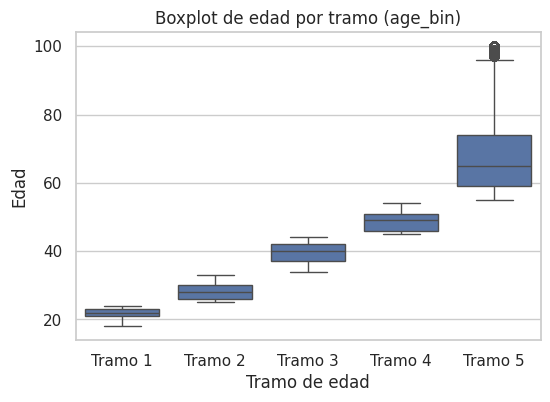

In [ ]:
# Boxplot de 'age' según los tramos 'age_bin'
plt.figure(figsize=(6, 4))
sns.boxplot(data=train, x='age_bin', y='age')
plt.title('Boxplot de edad por tramo (age_bin)')
plt.xlabel('Tramo de edad')
plt.ylabel('Edad')
plt.show()

### Renta

In [ ]:
# Mostrar número y porcentaje de valores nulos en 'renta' de train
print("train['renta'] →", train['renta'].isna().sum(), f"({train['renta'].isna().mean():.2%}) nulos")

# Mostrar número y porcentaje de valores nulos en 'renta' de test
print("test['renta'] →", test['renta'].isna().sum(), f"({test['renta'].isna().mean():.2%}) nulos")

train['renta'] → 0 (0.00%) nulos
test['renta'] → 0 (0.00%) nulos


In [ ]:
# Tipo de variable y valores únicos de 'renta' en train
print("train['renta'] →", train['renta'].dtype)
print("Valores únicos en train:", train['renta'].unique())

# Tipo de variable y valores únicos de 'renta' en test
print("test['renta'] →", test['renta'].dtype)
print("Valores únicos en test:", test['renta'].unique())

train['renta'] → float64
Valores únicos en train: [ 90408.75  90431.85  74708.49 ...  65721.15  96103.02 115609.44]
test['renta'] → object
Valores únicos en test: ['  326124.90' '         NA' '  148402.98' ... '  139164.12' '  100647.45'
 '   72765.27']


In [ ]:
# Limpiar espacios y reemplazar 'NA' por valores nulos reales
test['renta'] = test['renta'].str.strip().replace('NA', pd.NA)

# Convertir a tipo numérico (float), forzando errores como NA
test['renta'] = pd.to_numeric(test['renta'], errors='coerce')
# Convertir también train por si acaso a tipo float con soporte para nulos
train['renta'] = pd.to_numeric(train['renta'], errors='coerce')

In [ ]:
# Mostrar número y porcentaje de valores nulos en 'renta' de train
print("train['renta'] →", train['renta'].dtype)
print("train['renta'] →", train['renta'].isna().sum(), f"({train['renta'].isna().mean():.2%}) nulos")

# Mostrar número y porcentaje de valores nulos en 'renta' de test
print("test['renta'] →", test['renta'].dtype)
print("test['renta'] →", test['renta'].isna().sum(), f"({test['renta'].isna().mean():.2%}) nulos")

train['renta'] → float64
train['renta'] → 0 (0.00%) nulos
test['renta'] → float64
test['renta'] → 227965 (24.52%) nulos


In [ ]:
# Crear columna binaria que indica si el valor original de 'renta' era nulo antes de la imputación
train['renta_isnull'] = train['renta'].isna().astype(int)
test['renta_isnull'] = test['renta'].isna().astype(int)

In [ ]:
skewness = train['renta'].dropna().skew()
print(f"Asimetría (skew): {skewness:.2f}")
skewness = test['renta'].dropna().skew()
print(f"Asimetría (skew): {skewness:.2f}")

Asimetría (skew): 57.45
Asimetría (skew): 53.23


In [ ]:
# Calcular la mediana global de 'renta' en train
mediana_renta = train['renta'].median()

# Imputar los valores nulos con la mediana en train y test
train['renta'] = train['renta'].fillna(mediana_renta)
test['renta'] = test['renta'].fillna(mediana_renta)

In [ ]:
# Aplicar log1p a 'renta' para suavizar su distribución
train['renta_log'] = np.log1p(train['renta'])
test['renta_log'] = np.log1p(test['renta'])

In [ ]:
# Calcular cortes por cuantiles en train y extraer los bin_edges reales (sin duplicados)
_, bin_edges_log_5 = pd.qcut(train['renta_log'], q=5, retbins=True, duplicates='drop')

# Crear etiquetas dinámicamente según el número de tramos reales generados
labels_5 = [f'Tramo {i+1}' for i in range(len(bin_edges_log_5) - 1)]

# Aplicar pd.cut con los bin_edges y etiquetas
train['renta_bin'] = pd.cut(train['renta_log'], bins=bin_edges_log_5, labels=labels_5, include_lowest=True)
test['renta_bin'] = pd.cut(test['renta_log'], bins=bin_edges_log_5, labels=labels_5, include_lowest=True)

# Rellenar valores por debajo del mínimo con el primer tramo
test.loc[(test['renta_bin'].isna()) & (test['renta_log'] < bin_edges_log_5[0]), 'renta_bin'] = labels_5[0]

# Rellenar valores por encima del máximo con el último tramo
test.loc[(test['renta_bin'].isna()) & (test['renta_log'] > bin_edges_log_5[-1]), 'renta_bin'] = labels_5[-1]

In [ ]:
# Mostrar distribución de clientes por tramo de renta en train
print("Distribución de renta_bin en train:")
print(train['renta_bin'].value_counts().sort_index())

Distribución de renta_bin en train:
renta_bin
Tramo 1    79480
Tramo 2    79480
Tramo 3    79481
Tramo 4    79480
Tramo 5    79478
Name: count, dtype: int64


In [ ]:
# Mostrar distribución de clientes por tramo de renta en train
print("Distribución de renta_bin en test:")
print(test['renta_bin'].value_counts().sort_index())

Distribución de renta_bin en test:
renta_bin
Tramo 1    141555
Tramo 2    141436
Tramo 3    367904
Tramo 4    139317
Tramo 5    139403
Name: count, dtype: int64


In [ ]:
print("Mínimo en test:", test['renta_log'].min())
print("Máximo en test:", test['renta_log'].max())
print("Rango en cortes:", bin_edges_log_5[0], "→", bin_edges_log_5[-1])

Mínimo en test: 7.093180348228723
Máximo en test: 17.179158241895557
Rango en cortes: 7.093180348228723 → 17.179158241895557


In [ ]:
print("Tramos únicos en train:", sorted(train['renta_bin'].unique()))
print("Tramos únicos en test :", sorted(test['renta_bin'].unique()))

Tramos únicos en train: ['Tramo 1', 'Tramo 2', 'Tramo 3', 'Tramo 4', 'Tramo 5']
Tramos únicos en test : ['Tramo 1', 'Tramo 2', 'Tramo 3', 'Tramo 4', 'Tramo 5']


In [ ]:
# Mostrar distribución de clientes por tramo de renta en test
print("Distribución de renta_bin en test:")
print(test['renta_bin'].value_counts().sort_index())

Distribución de renta_bin en test:
renta_bin
Tramo 1    141555
Tramo 2    141436
Tramo 3    367904
Tramo 4    139317
Tramo 5    139403
Name: count, dtype: int64


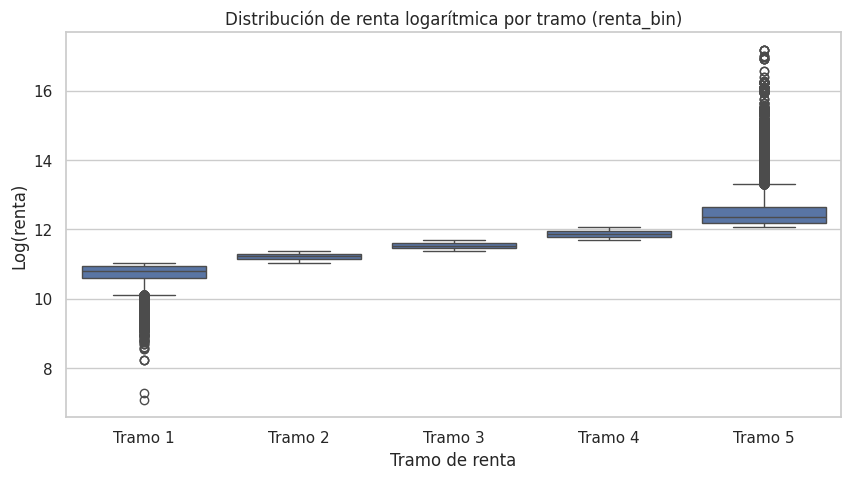

In [ ]:
# Visualizar la distribución de renta imputada por tramo categórico
plt.figure(figsize=(10, 5))
sns.boxplot(data=train, x='renta_bin', y='renta_log')
plt.title('Distribución de renta logarítmica por tramo (renta_bin)')
plt.xlabel('Tramo de renta')
plt.ylabel('Log(renta)')
plt.show()

In [ ]:
# Calcular límites de outliers con log(renta)
q1 = train['renta_log'].quantile(0.25)
q3 = train['renta_log'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Crear variable binaria de outliers en train y test
train['renta_outlier'] = ((train['renta_log'] < lower_bound) | (train['renta_log'] > upper_bound)).astype(int)
test['renta_outlier'] = ((test['renta_log'] < lower_bound) | (test['renta_log'] > upper_bound)).astype(int)

### Antigüedad

In [ ]:
# Mostrar número y porcentaje de valores nulos en 'antiguedad' de train
print("train['antiguedad'] →", train['antiguedad'].isna().sum(), f"({train['antiguedad'].isna().mean():.2%}) nulos")

# Mostrar número y porcentaje de valores nulos en 'antiguedad' de test
print("test['antiguedad'] →", test['antiguedad'].isna().sum(), f"({test['antiguedad'].isna().mean():.2%}) nulos")

train['antiguedad'] → 0 (0.00%) nulos
test['antiguedad'] → 0 (0.00%) nulos


In [ ]:
# Tipo de variable y valores únicos de 'antiguedad' en train
print("train['antiguedad'] →", train['antiguedad'].dtype)
print("Valores únicos en train:", train['antiguedad'].unique())

# Tipo de variable y valores únicos de 'antiguedad' en test
print("test['antiguedad'] →", test['antiguedad'].dtype)
print("Valores únicos en test:", test['antiguedad'].unique())

train['antiguedad'] → object
Valores únicos en train: ['     35' '     34' '     12' '      7' '     36' '     38' '     28'
 '     39' '      4' '     37' '     19' '     18' '     16' '     14'
 '      8' '     10' '     21' '     20' '     32' '     31' '     25'
 '     29' '     22' '     27' '     26' '      2' '     30' '     33'
 '     47' '     46' '     24' '     13' '     45' '     57' '     52'
 '     51' '     58' '     56' '     55' '     59' '     54' '     53'
 '     62' '     61' '     63' '     60' '     49' '     48' '     50'
 '     40' '     41' '     43' '     44' '     23' '     42' '     17'
 '     11' '     15' '      9' '      3' '      1' '      6' '      5'
 '    165' '    128' '     72' '    162' '    146' '     77' '    161'
 '    110' '     69' '    164' '    138' '    136' '     83' '    166'
 '    167' '     93' '    168' '    159' '    120' '     88' '     84'
 '    156' '     95' '    141' '     78' '    149' '    206' '    172'
 '    179' '    101' ' 

In [ ]:
# Limpiar espacios y reemplazar valores no numéricos por nulos en 'antiguedad' de train
train['antiguedad'] = train['antiguedad'].str.strip()
train['antiguedad'] = pd.to_numeric(train['antiguedad'], errors='coerce')

# Convertir 'antiguedad' de test a numérico por si acaso (si ya es numérico, no pasará nada)
test['antiguedad'] = pd.to_numeric(test['antiguedad'], errors='coerce')

train['antiguedad'] = train['antiguedad'].astype(int)
test['antiguedad'] = test['antiguedad'].astype(int)

In [ ]:
# Comprobar el tipo de dato de 'antiguedad' en train y test
print("train['antiguedad'] →", train['antiguedad'].dtype)
print("test['antiguedad'] →", test['antiguedad'].dtype)

train['antiguedad'] → int64
test['antiguedad'] → int64


In [ ]:
# Reemplazar -999999 por NaN en 'antiguedad' de train y test
train['antiguedad'] = train['antiguedad'].replace(-999999, np.nan)
test['antiguedad'] = test['antiguedad'].replace(-999999, np.nan)

# Mostrar número y porcentaje de valores nulos en 'antiguedad' de train
print("train['antiguedad'] →", train['antiguedad'].isna().sum(), f"({train['antiguedad'].isna().mean():.2%}) nulos")

# Mostrar número y porcentaje de valores nulos en 'antiguedad' de test
print("test['antiguedad'] →", test['antiguedad'].isna().sum(), f"({test['antiguedad'].isna().mean():.2%}) nulos")

train['antiguedad'] → 0 (0.00%) nulos
test['antiguedad'] → 3 (0.00%) nulos


In [ ]:
# Crear columna binaria que indica si el valor original de 'antiguedad' era nulo
train['antiguedad_isnull'] = train['antiguedad'].isna().astype(int)
test['antiguedad_isnull'] = test['antiguedad'].isna().astype(int)

# Calcular la mediana global de 'antiguedad'
mediana_antiguedad = train['antiguedad'].median()

# Imputar los valores nulos con la mediana en train y test
train['antiguedad'] = train['antiguedad'].fillna(mediana_antiguedad)
test['antiguedad'] = test['antiguedad'].fillna(mediana_antiguedad)

In [ ]:
# Calcular cortes por cuantiles en train para antigüedad y extraer bin_edges reales
_, bin_edges_ant = pd.qcut(train['antiguedad'], q=5, retbins=True, duplicates='drop')

# Crear etiquetas dinámicas para los tramos
labels_ant = [f'Tramo {i+1}' for i in range(len(bin_edges_ant) - 1)]

# Aplicar pd.cut con los bin_edges y etiquetas
train['antiguedad_bin'] = pd.cut(train['antiguedad'], bins=bin_edges_ant, labels=labels_ant, include_lowest=True)
test['antiguedad_bin'] = pd.cut(test['antiguedad'], bins=bin_edges_ant, labels=labels_ant, include_lowest=True)

# Rellenar valores por debajo del mínimo con el primer tramo
test.loc[(test['antiguedad_bin'].isna()) & (test['antiguedad'] < bin_edges_ant[0]), 'antiguedad_bin'] = labels_ant[0]

# Rellenar valores por encima del máximo con el último tramo
test.loc[(test['antiguedad_bin'].isna()) & (test['antiguedad'] > bin_edges_ant[-1]), 'antiguedad_bin'] = labels_ant[-1]

# Rellenar cualquier NaN restante con el tramo más cercano (por seguridad)
test['antiguedad_bin'] = test['antiguedad_bin'].fillna(labels_ant[0])

In [ ]:
# Mostrar distribución de clientes por tramo de renta en train
print("Distribución de antiguedad_bin en test:")
print(test['antiguedad_bin'].value_counts().sort_index())

Distribución de antiguedad_bin en test:
antiguedad_bin
Tramo 1    220905
Tramo 2    156040
Tramo 3    209766
Tramo 4    164626
Tramo 5    178278
Name: count, dtype: int64


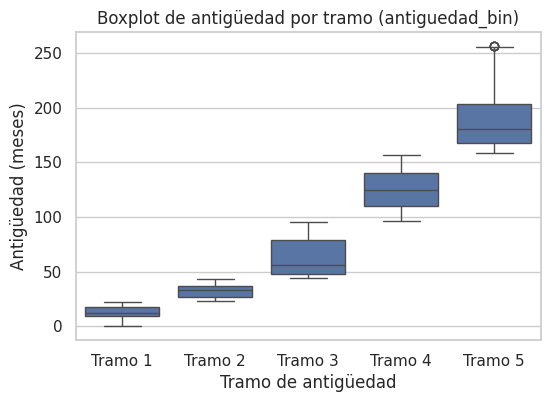

In [ ]:
# Boxplot de 'antiguedad' según los tramos 'antiguedad_bin'
plt.figure(figsize=(6, 4))
sns.boxplot(data=train, x='antiguedad_bin', y='antiguedad')
plt.title('Boxplot de antigüedad por tramo (antiguedad_bin)')
plt.xlabel('Tramo de antigüedad')
plt.ylabel('Antigüedad (meses)')
plt.show()

### Boxplot e Histogramas

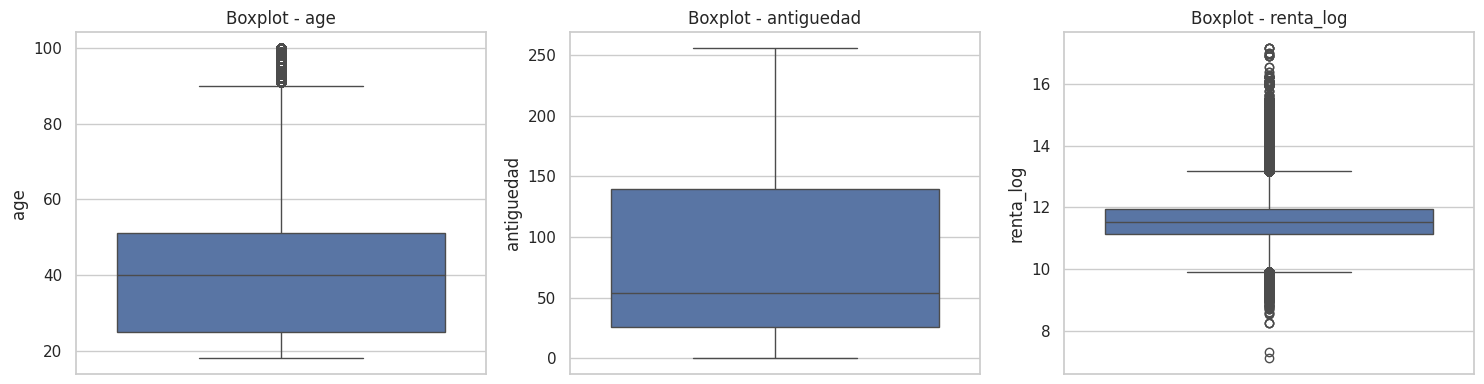

In [ ]:
# Seleccionar variables numéricas a representar
vars_num = ['age', 'antiguedad', 'renta_log']

# Crear boxplots para cada variable (3 por fila)
plt.figure(figsize=(15, 4))
for i, col in enumerate(vars_num):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(y=train[col])
    plt.title(f'Boxplot - {col}')
plt.tight_layout()
plt.show()

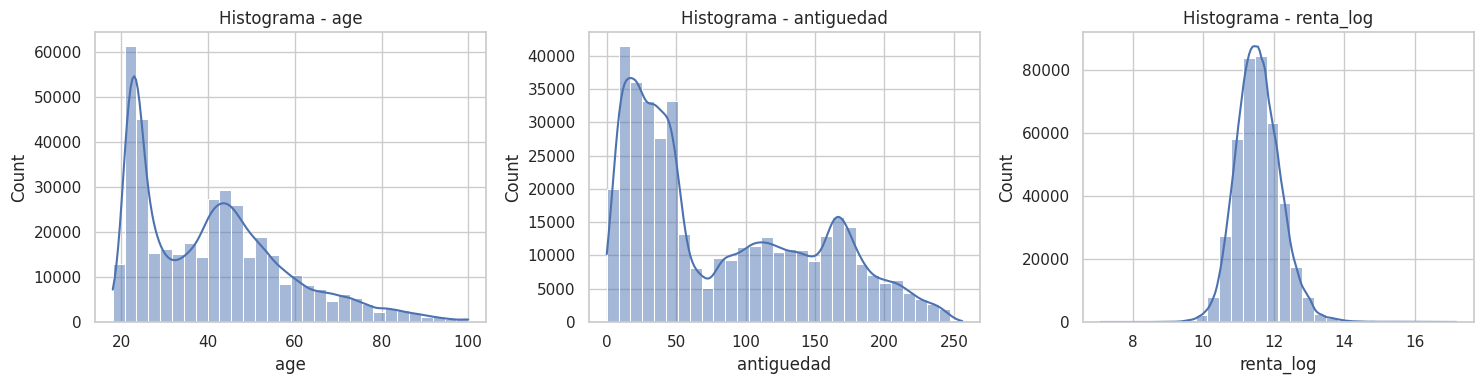

In [ ]:
# Crear histogramas para cada variable (3 por fila)
plt.figure(figsize=(15, 4))
for i, col in enumerate(vars_num):
    plt.subplot(1, 3, i + 1)
    sns.histplot(train[col], kde=True, bins=30)
    plt.title(f'Histograma - {col}')
plt.tight_layout()
plt.show()

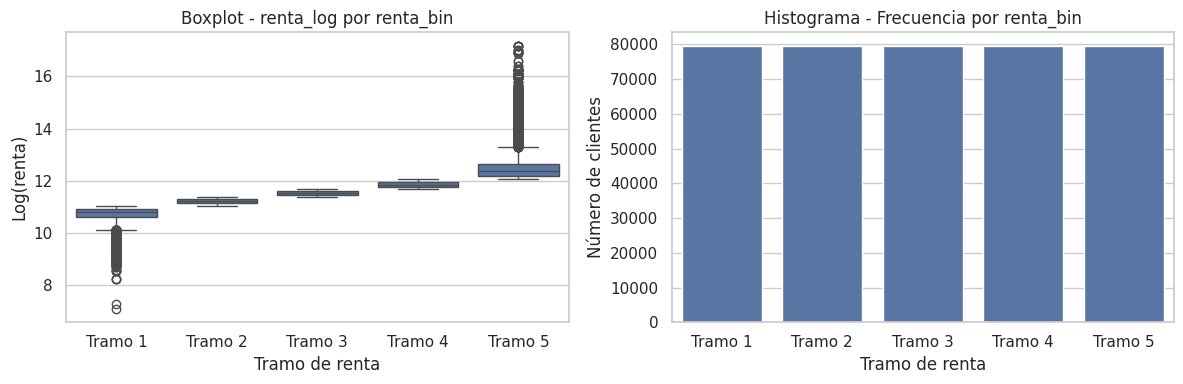

In [ ]:
# Crear boxplot y histograma de 'renta_bin' en la misma línea
plt.figure(figsize=(12, 4))

# Boxplot de 'renta_log' por tramo de renta_bin
plt.subplot(1, 2, 1)
sns.boxplot(data=train, x='renta_bin', y='renta_log')
plt.title('Boxplot - renta_log por renta_bin')
plt.xlabel('Tramo de renta')
plt.ylabel('Log(renta)')

# Histograma de frecuencia de cada tramo de renta_bin
plt.subplot(1, 2, 2)
sns.countplot(data=train, x='renta_bin', order=sorted(train['renta_bin'].unique()))
plt.title('Histograma - Frecuencia por renta_bin')
plt.xlabel('Tramo de renta')
plt.ylabel('Número de clientes')

plt.tight_layout()
plt.show()

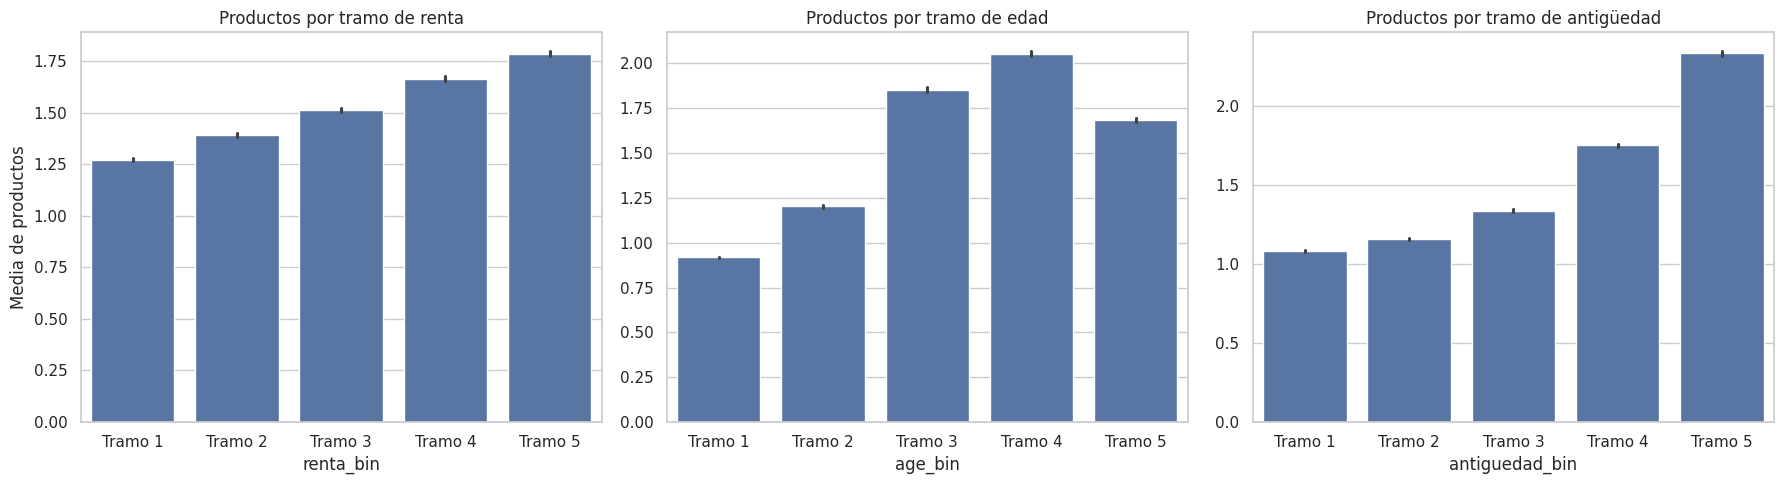

In [ ]:
# Calcular la media de productos contratados por tramo de renta
media_productos_por_renta = train.groupby('renta_bin')['num_productos'].mean().reset_index()

# Crear figura con 3 subplots en una sola fila
plt.figure(figsize=(18, 5))

# Media de productos por tramo de renta
plt.subplot(1, 3, 1)
sns.barplot(data=train, x='renta_bin', y='num_productos', order=sorted(train['renta_bin'].unique()))
plt.title('Productos por tramo de renta')
plt.xlabel('renta_bin')
plt.ylabel('Media de productos')

# Media de productos por tramo de edad
plt.subplot(1, 3, 2)
sns.barplot(data=train, x='age_bin', y='num_productos', order=sorted(train['age_bin'].unique()))
plt.title('Productos por tramo de edad')
plt.xlabel('age_bin')
plt.ylabel('')

# Media de productos por tramo de antigüedad
plt.subplot(1, 3, 3)
sns.barplot(data=train, x='antiguedad_bin', y='num_productos', order=sorted(train['antiguedad_bin'].unique()))
plt.title('Productos por tramo de antigüedad')
plt.xlabel('antiguedad_bin')
plt.ylabel('')

plt.tight_layout()
plt.show()


## Comprobación

In [ ]:
# Recalcular resumen actualizado
resumen_train = pd.DataFrame({
    'porc_nulos_train': train.isna().mean() * 100,
    'tipo_dato_train': train.dtypes,
    'valores_unicos_train': train.nunique(dropna=False)
})

resumen_test = pd.DataFrame({
    'porc_nulos_test': test.isna().mean() * 100,
    'tipo_dato_test': test.dtypes,
    'valores_unicos_test': test.nunique(dropna=False)
})

# Convertir columnas de valores únicos a enteros (tipo pandas Int64 para permitir nulos si los hay)
resumen_train['valores_unicos_train'] = resumen_train['valores_unicos_train'].astype('Int64')
resumen_test['valores_unicos_test'] = resumen_test['valores_unicos_test'].astype('Int64')

resumen_completo = pd.concat([resumen_train, resumen_test], axis=1).round(2)

# Filtrar filas con diferente tipo de dato (excluyendo NaN en test) o que tengan algún porcentaje de nulos
diferencias_o_nulos = resumen_completo[
    (resumen_completo['tipo_dato_train'] != resumen_completo['tipo_dato_test']) & resumen_completo['tipo_dato_test'].notna() |
    (resumen_completo['porc_nulos_train'] > 0) |
    (resumen_completo['porc_nulos_test'] > 0)
]

display(diferencias_o_nulos)

,porc_nulos_train,tipo_dato_train,valores_unicos_train,porc_nulos_test,tipo_dato_test,valores_unicos_test
antiguedad,0.0,int64,257,0.0,float64,258
tiprel_1mes_lgb,0.0,category,5,0.0,category,4
indrel_1mes_cat,0.0,category,6,0.0,category,3


In [ ]:
# Definir función robusta para comprobar si un dtype es entero
def es_entero(dtype):
    try:
        return np.issubdtype(np.dtype(dtype), np.integer)
    except TypeError:
        return False

# Aplicar la función solo a columnas presentes en ambos DataFrames
comunes = train.columns.intersection(test.columns)

# Crear DataFrame con tipos de dato de columnas comunes
dtypes_comunes = pd.DataFrame({
    'tipo_dato_train': train[comunes].dtypes,
    'tipo_dato_test': test[comunes].dtypes
})

# Detectar si el tipo de dato es entero en ambos datasets
enteros_train = dtypes_comunes['tipo_dato_train'].apply(es_entero)
enteros_test = dtypes_comunes['tipo_dato_test'].apply(es_entero)

# Identificar columnas que no son enteras en ambos
no_enteros = ~(enteros_train & enteros_test)

# Filtrar el DataFrame con las columnas no enteras y hacer una copia segura
dtypes_diff = dtypes_comunes.loc[no_enteros].copy()

# Añadir columnas para detectar si alguno es tipo 'object'
dtypes_diff['es_object_en_train'] = dtypes_diff['tipo_dato_train'].apply(lambda x: x == 'object')
dtypes_diff['es_object_en_test'] = dtypes_diff['tipo_dato_test'].apply(lambda x: x == 'object')

# Mostrar el DataFrame resultante
display(dtypes_diff)

,tipo_dato_train,tipo_dato_test,es_object_en_train,es_object_en_test
sexo,category,category,False,False
age,Int64,Int64,False,False
antiguedad,int64,float64,False,False
renta,float64,float64,False,False
canal_entradacat,category,category,False,False
ind_empleado_lgb,category,category,False,False
tiprel_1mes_lgb,category,category,False,False
indrel_1mes_cat,category,category,False,False
age_bin,category,category,False,False
renta_log,float64,float64,False,False


## Variables Objetivo

In [ ]:
# Obtener las columnas exclusivas de train (no están en test)
columnas_solo_train = list(set(train.columns) - set(test.columns))

# Eliminar filas que tengan valores nulos en cualquiera de esas columnas
train = train.dropna(subset=columnas_solo_train)

In [ ]:
# Crear DataFrame con tipo de dato y número de valores únicos de las columnas exclusivas de train
resumen_solo_train = pd.DataFrame({
    'tipo_dato': train[columnas_solo_train].dtypes,
    'valores_unicos': train[columnas_solo_train].nunique(dropna=False)
})

# Mostrar el DataFrame
display(resumen_solo_train)

,tipo_dato,valores_unicos
ind_ctju_fin_ult1,int64,2
ind_hip_fin_ult1,int64,2
ind_cder_fin_ult1,int64,2
ind_viv_fin_ult1,int64,2
ind_nom_pens_ult1,float64,2
ind_deco_fin_ult1,int64,2
ind_ecue_fin_ult1,int64,2
ind_ctma_fin_ult1,int64,2
ind_aval_fin_ult1,int64,2
ind_dela_fin_ult1,int64,2


In [ ]:
# Eliminar la columna 'num_productos' de train
train = train.drop(columns='num_productos')

# Lista de columnas a convertir a binario
columnas_binarias = [col for col in columnas_solo_train if col != 'num_productos']

# Convertir todas esas columnas a tipo binario (0 o 1) y tipo int8
train[columnas_binarias] = train[columnas_binarias].astype('int8')

# FEATURE ENGINEERING

In [ ]:
train_clean = train.copy()
test_clean = test.copy()

In [ ]:
# Crear DataFrame con los tipos de datos solo para las columnas comunes entre train_clean y test_clean
common_cols = train_clean.columns.intersection(test_clean.columns)

# Construir el DataFrame con los dtypes de columnas comunes
dtypes_df_common = pd.DataFrame({
    'train_dtype': train_clean[common_cols].dtypes,
    'test_dtype': test_clean[common_cols].dtypes
})

# Mostrar el DataFrame resultante
dtypes_df_common

,train_dtype,test_dtype
ncodpers,int64,int64
pais_residencia,int64,int64
sexo,category,category
age,Int64,Int64
ind_nuevo,int64,int64
antiguedad,int64,float64
indrel,int8,int8
indresi,int64,int64
indext,int64,int64
cod_prov,int64,int64


## age

In [ ]:
# Eliminamos la columna 'age' porque vamos a trabajar con la variable categórica 'age_bin'
train_clean.drop(columns=['age'], inplace=True)
test_clean.drop(columns=['age'], inplace=True)

## renta

In [ ]:
# Eliminamos las columnas 'renta' y 'renta_log' porque trabajaremos con 'renta_bin' y 'renta_isnull'
train_clean.drop(columns=['renta', 'renta_log'], inplace=True)
test_clean.drop(columns=['renta', 'renta_log'], inplace=True)

## antiguedad

In [ ]:
# Eliminamos la columna 'antiguedad' porque trabajaremos con 'antiguedad_bin' y 'antiguedad_isnull'
train_clean.drop(columns=['antiguedad'], inplace=True)
test_clean.drop(columns=['antiguedad'], inplace=True)

## segmento

In [ ]:
# Eliminamos la columna 'segmento' si ya fue codificada como 'segmento_cod'
train_clean.drop(columns=['segmento'], inplace=True, errors='ignore')
test_clean.drop(columns=['segmento'], inplace=True, errors='ignore')

In [ ]:
# Mostrar columnas comunes entre train y test, una por línea
for col in train_clean.columns.intersection(test_clean.columns):
    print(col)

ncodpers
pais_residencia
sexo
ind_nuevo
indrel
indresi
indext
cod_prov
ind_actividad_cliente
tiene_fecha_cli_1t
segmento_cod
canal_entrada_le
canal_entradacat
ind_empleado_lgb
tiprel_1mes_lgb
tiprel_1mes_xgb
indrel_1mes_label
indrel_1mes_cat
age_bin
renta_isnull
renta_bin
renta_outlier
antiguedad_isnull
antiguedad_bin


## columnas redundantes

In [ ]:
# Eliminar columnas redundantes y específicas de XGBoost que no se usarán en LightGBM
cols_to_drop_lgb = [
    # 'ind_empleado_xgb',    # versión para XGBoost
    'tiprel_1mes_xgb',     # versión para XGBoost
    'indrel_1mes_label',    # versión codificada para XGBoost
    'canal_entrada_le',   # versión codificada para LightGBM
]

# Eliminar esas columnas de train_clean y test_clean
train_clean = train_clean.drop(columns=cols_to_drop_lgb)

# Eliminar columnas redundantes y específicas de XGBoost que no se usarán en LightGBM
cols_to_drop_lgb = [
    # 'ind_empleado_xgb',    # versión para XGBoost
    'tiprel_1mes_xgb',     # versión para XGBoost
    'indrel_1mes_label',    # versión codificada para XGBoost
    'canal_entrada_le',   # versión codificada para LightGBM
]

test_clean = test_clean.drop(columns=cols_to_drop_lgb)

## Comprobación

In [ ]:
# Crear DataFrame con tipos de dato de train_clean
dtypes_train = pd.DataFrame(train_clean.dtypes, columns=['tipo_dato_train'])

# Crear DataFrame con tipos de dato de test_clean
dtypes_test = pd.DataFrame(test_clean.dtypes, columns=['tipo_dato_test'])

# Unir ambos por índice (nombre de columna), dejando NA donde no coincidan
resumen_tipos = pd.concat([dtypes_train, dtypes_test], axis=1)

# Reordenar las columnas para que las que terminan en '_ult1' aparezcan al final
orden_columnas = sorted(resumen_tipos.index, key=lambda x: (x.endswith('_ult1'), x))

# Reindexar el DataFrame con el nuevo orden
resumen_tipos = resumen_tipos.loc[orden_columnas]

# Mostrar el DataFrame resultante
display(resumen_tipos)

,tipo_dato_train,tipo_dato_test
age_bin,category,category
antiguedad_bin,category,category
antiguedad_isnull,int64,int64
canal_entradacat,category,category
cod_prov,int64,int64
ind_actividad_cliente,int64,int64
ind_empleado_lgb,category,category
ind_nuevo,int64,int64
indext,int64,int64
indrel,int8,int8


In [ ]:
# Obtener columnas objetivo: están solo en train_clean
columnas_objetivo = list(set(train_clean.columns) - set(test_clean.columns))

# Obtener columnas predictoras: están en ambos datasets
columnas_predictoras = list(set(train_clean.columns).intersection(set(test_clean.columns)))

# Mostrar resumen
print("Número de columnas objetivo:", len(columnas_objetivo))
print("Número de columnas predictoras:", len(columnas_predictoras))
print("Número de columnas en test_clean:", len(test_clean.columns))
print("¿Coinciden columnas_predictoras y test_clean.columns?", set(columnas_predictoras) == set(test_clean.columns))

# Comprobación adicional: total de columnas = predictoras + objetivo
total = len(columnas_predictoras) + len(columnas_objetivo)
print("¿Coinciden columnas objetivo + predictoras con columnas de train_clean?", total == len(train_clean.columns))

Número de columnas objetivo: 24
Número de columnas predictoras: 21
Número de columnas en test_clean: 21
¿Coinciden columnas_predictoras y test_clean.columns? True
¿Coinciden columnas objetivo + predictoras con columnas de train_clean? True


# MODELO

¡Buena reflexión! La idea de **clusterizar clientes y entrenar modelos distintos por grupo** es interesante y puede funcionar, **pero no siempre mejora el rendimiento**. En un problema como el de Santander (recomendación de productos bancarios mensuales), te dejo pros, contras y una estrategia razonable si decides intentarlo:

---

### ✅ Cuándo puede tener sentido clusterizar en este caso

- Hay **mucha heterogeneidad entre clientes**: edad, nivel económico, país, canal de entrada...
- El comportamiento de los clientes puede variar por **segmento natural** (jóvenes vs mayores, extranjeros vs locales, etc.).
- Quieres probar una arquitectura tipo **"mixture of experts"** (cada modelo especializado en un subconjunto).

---

### ⚠️ Riesgos o desventajas

- Si los **clusters no tienen relación real con la variable objetivo**, separar el dataset puede **empeorar el rendimiento**.
- Puedes **duplicar esfuerzo de modelado**: necesitas un pipeline por grupo.
- El **riesgo de overfitting** aumenta si algunos clusters tienen pocos datos.

---

### 💡 Recomendación si decides hacerlo

1. **Normaliza solo variables numéricas** (edad, renta, antigüedad...).
2. Aplica **KMeans o MiniBatchKMeans** para segmentar en pocos grupos (`k=3~6`).
3. Añade el cluster como una **nueva variable** (`train['cluster'] = ...`) y:
   - a) Entrenas un solo modelo con esa variable.
   - b) O bien entrenas un modelo **por cluster** y haces `predict()` por grupo.

---

### 🧠 Alternativa más segura

En lugar de clusterizar sin supervisión, puedes:
- Hacer **stratified group KFold** por alguna variable como `segmento`, `sexo`, o una combinación de variables socioeconómicas.
- O entrenar un modelo base, y usar su error para clusterizar clientes según residuales (`error-based clustering`).

---

¿Quieres que prepare código para probar un clustering simple (por KMeans) sobre clientes? ¿O prefieres explorar qué variables podrían ser más discriminativas para hacer grupos?

In [ ]:
train_mod = train_clean.copy()
test_mod = test_clean.copy()

In [ ]:
# Separar train_mod en train y validación, manteniendo ncodpers
train_data, val_data = train_test_split(train_mod, test_size=0.2, random_state=42)

# Lista de productos: columnas que terminan en 'ult1'
productos = [col for col in train_mod.columns if col.endswith('ult1')]

# Features: todo excepto los productos
features = [col for col in train_mod.columns if col not in productos]

# Preparar X e y
X_train = train_data[features]
X_val = val_data[features]

y_train = train_data[productos]
y_val = val_data[productos]

# Detectar columnas categóricas
categorical_feats = X_train.select_dtypes(include=['category']).columns.tolist()

In [ ]:
productos

['ind_ahor_fin_ult1',
 'ind_aval_fin_ult1',
 'ind_cco_fin_ult1',
 'ind_cder_fin_ult1',
 'ind_cno_fin_ult1',
 'ind_ctju_fin_ult1',
 'ind_ctma_fin_ult1',
 'ind_ctop_fin_ult1',
 'ind_ctpp_fin_ult1',
 'ind_deco_fin_ult1',
 'ind_deme_fin_ult1',
 'ind_dela_fin_ult1',
 'ind_ecue_fin_ult1',
 'ind_fond_fin_ult1',
 'ind_hip_fin_ult1',
 'ind_plan_fin_ult1',
 'ind_pres_fin_ult1',
 'ind_reca_fin_ult1',
 'ind_tjcr_fin_ult1',
 'ind_valo_fin_ult1',
 'ind_viv_fin_ult1',
 'ind_nomina_ult1',
 'ind_nom_pens_ult1',
 'ind_recibo_ult1']

In [ ]:
# Comprobar si todos los productos están en train_data y val_data
faltan_en_train = [col for col in productos if col not in train_data.columns]
faltan_en_val = [col for col in productos if col not in val_data.columns]

print("Faltan en train_data:", faltan_en_train)
print("Faltan en val_data:", faltan_en_val)


Faltan en train_data: []
Faltan en val_data: []


## Entrenamiento multi-producto (loop)

In [ ]:
# Almacenar modelos entrenados por producto con LightGBM
modelos = {}
val_preds = val_data[['ncodpers']].copy()

# Asegurar que las columnas de productos están en tipo int estándar (Python) para evitar errores con LightGBM
train_data[productos] = train_data[productos].astype(int)
val_data[productos] = val_data[productos].astype(int)

# Iteramos por cada producto
for prod in productos:
    print(f'\n=== Entrenando modelo para producto {prod} ===')

    # Variables objetivo
    y_tr = train_data[prod]
    y_vl = val_data[prod]

    # Instanciar el modelo LGBM
    modelo = LGBMClassifier(
        objective='binary',
        learning_rate=0.05,
        num_leaves=64,
        max_depth=7,
        n_estimators=1000,
        random_state=42
    )

    # Comprobar que y_tr contiene al menos dos clases antes de entrenar
    if len(y_tr.unique()) < 2:
        print(f'⚠️ Solo una clase presente en el entrenamiento para {prod}. Se rellenan predicciones con 0.')
        val_preds[prod] = 0.0
        continue

    # Entrenar con callbacks para early stopping y log
    modelo.fit(
        train_data[features], y_tr,
        eval_set=[(val_data[features], y_vl)],
        eval_metric='auc',
        callbacks=[
            early_stopping(stopping_rounds=50),
            log_evaluation(period=50)
        ],
        categorical_feature=categorical_feats
    )

    # Guardar modelo
    modelos[prod] = modelo

    # Guardar predicciones
    val_preds[prod] = modelo.predict_proba(val_data[features])[:, 1]

print("Modelos entrenados sin clustering con LightGBM.")


=== Entrenando modelo para producto ind_ahor_fin_ult1 ===
[LightGBM] [Info] Number of positive: 37, number of negative: 317874
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 374
[LightGBM] [Info] Number of data points in the train set: 317911, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000116 -> initscore=-9.058492
[LightGBM] [Info] Start training from score -9.058492
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

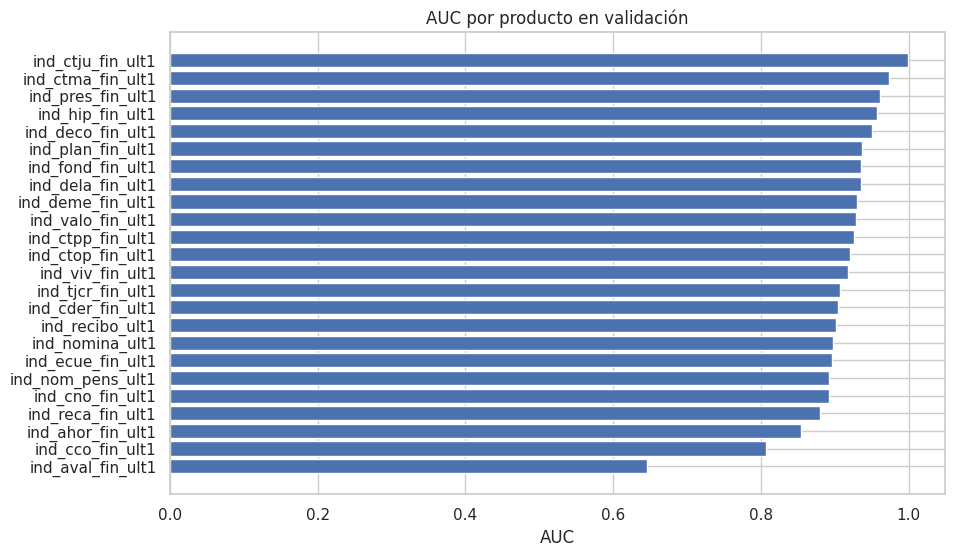

In [ ]:
# Calcular AUC para cada producto y mostrarlo en una gráfica
from sklearn.metrics import roc_auc_score

# Lista para guardar resultados
auc_scores = []

# Calcular AUC solo para productos con predicciones y ground truth válidos
for prod in productos:
    if prod in val_preds.columns and prod in val_data.columns:
        try:
            score = roc_auc_score(val_data[prod], val_preds[prod])
            auc_scores.append((prod, score))
        except ValueError:
            print(f"No se puede calcular AUC para {prod} (clases únicas en val_data)")

# Ordenar resultados por AUC
auc_scores.sort(key=lambda x: x[1], reverse=True)

# Separar nombres y valores
prod_names = [x[0] for x in auc_scores]
prod_auc = [x[1] for x in auc_scores]

# Mostrar gráfica de AUC por producto
plt.figure(figsize=(10, 6))
plt.barh(prod_names[::-1], prod_auc[::-1])
plt.xlabel("AUC")
plt.title("AUC por producto en validación")
plt.grid(True)
plt.show()

In [ ]:
# Crear un DataFrame con los valores de AUC por producto
df_auc = pd.DataFrame(auc_scores, columns=['producto', 'auc']).sort_values(by='auc', ascending=False)
df_auc

,producto,auc
0,ind_ctju_fin_ult1,0.999109
1,ind_ctma_fin_ult1,0.973074
2,ind_pres_fin_ult1,0.961215
3,ind_hip_fin_ult1,0.957172
4,ind_deco_fin_ult1,0.950876
5,ind_plan_fin_ult1,0.936158
6,ind_fond_fin_ult1,0.935223
7,ind_dela_fin_ult1,0.934950
8,ind_deme_fin_ult1,0.929948
9,ind_valo_fin_ult1,0.928926


## Evaluación multi-producto MAP@7 (validación)

MAP@7 (multi-producto) validación: 0.03675

Lo que representa claramente el rendimiento del modelo según la métrica oficial del proyecto (MAP@7).

Conclusión:

Sí, la celda 2 muestra claramente los resultados del modelo en validación usando la métrica de Kaggle (MAP@7).

Usa este valor para saber cómo se desempeña tu modelo antes de generar la submission final.

¿Quieres aclarar algo más antes de avanzar?

In [ ]:
# Comprobar qué columnas faltan
productos_faltantes = [p for p in productos if p not in val_preds.columns]
print("Productos que faltan en val_preds:", productos_faltantes)

Productos que faltan en val_preds: []


In [ ]:
# Reconstruir pred_dict a partir de las predicciones
pred_dict = {
    int(row['ncodpers']): row[productos].tolist()  # Obtener las predicciones de todos los productos
    for _, row in val_preds.iterrows()
}

# Reconstruir true_dict con índices como int
true_dict = {
    int(idx): row[row == 1].index.tolist()
    for idx, row in val_data[productos].iterrows()
    if row.sum() > 0
}

# Asegurarte de que pred_dict también tiene índices como int
pred_dict = {int(k): v for k, v in pred_dict.items()}

print("Nº de predicciones generadas:", len(pred_dict))
print("Nº de valores verdaderos disponibles:", len(true_dict))

# Opcional: muestra algunos ejemplos para verificar el contenido
for k in list(pred_dict.keys())[:3]:
    print("Cliente:", k)
    print("Predicción:", pred_dict[k])
    print("Verdadero:", true_dict.get(k, []))

Nº de predicciones generadas: 75302
Nº de valores verdaderos disponibles: 65454
Cliente: 1318551
Predicción: [4.0985733963585385e-06, 1.4133791175326662e-05, 0.9509942793265221, 1.893212350841239e-05, 9.975683467388322e-05, 1.322582413374815e-07, 2.578137216847162e-06, 3.4503545142232358e-09, 6.716997272025373e-09, 0.0015355458318036428, 3.869600636058087e-08, 6.949646679945434e-07, 2.9200665840066238e-05, 4.823375468875745e-09, 5.02351209719384e-10, 8.885602950206771e-10, 2.4100079372337905e-06, 8.259623896356825e-07, 1.1201823399785931e-06, 2.358692244564761e-08, 6.392151488054337e-10, 8.0664260163167e-07, 3.1926082112576627e-06, 0.0001531545851543717]
Verdadero: []
Cliente: 1215543
Predicción: [2.602242933928072e-06, 1.4133791175326662e-05, 0.24973200503519147, 1.8931809251329277e-05, 0.00030217299818098917, 8.051026584140901e-07, 5.285823923695806e-06, 1.187201677942634e-09, 7.790747198496674e-10, 0.0015355458318036428, 5.650893236923978e-08, 1.478028814420094e-06, 9.09336373756462

In [ ]:
# Funciones de evaluación
def apk(actual, predicted, k=7):
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return score / min(len(actual), k)

def mapk(actual, predicted, k=7):
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

# Reconstruir true_dict desde val_data
true_dict = {
    int(idx): row[row == 1].index.tolist()
    for idx, row in val_data[productos].iterrows()
    if row.sum() > 0
}

# Reconstruir pred_dict desde val_preds
pred_dict = {
    int(row['ncodpers']): row[productos].sort_values(ascending=False).index.tolist()[:7]
    for _, row in val_preds.iterrows()
}

# Evaluar solo sobre clientes presentes en ambos diccionarios
clientes_validos = list(set(true_dict.keys()).intersection(pred_dict.keys()))
actual = [true_dict[c] for c in clientes_validos]
predicted = [pred_dict[c] for c in clientes_validos]

# Calcular y mostrar MAP@7
map7_score = mapk(actual, predicted, k=7)
print(f'MAP@7 (multi-producto) validación: {map7_score:.5f}')

MAP@7 (multi-producto) validación: 0.66900


## Generar predicciones finales en TEST para submission

In [ ]:
# Preparar X_test con ncodpers incluido
X_test = test_mod[features]

# Crear DataFrame con ncodpers
test_preds = test_mod[['ncodpers']].copy()

# Predecir cada producto en test con predict_proba
for prod in productos:
    test_preds[prod] = modelos[prod].predict_proba(X_test)[:, 1]

# Generar lista de productos top-7 por cliente
submission = []
for idx, row in test_preds.iterrows():
    cliente = int(row['ncodpers'])  # Asegurar que es entero
    top_products = row[productos].sort_values(ascending=False).index.tolist()[:7]
    added_products = ' '.join(top_products)
    submission.append([cliente, added_products])

# Guardar submission final
submission_df = pd.DataFrame(submission, columns=['ncodpers', 'added_products'])
submission_df['ncodpers'] = submission_df['ncodpers'].astype('int')  # Convertir a entero

# Guardar y descargar
submission_df.to_csv('submission.csv', index=False)

from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
submission_df.head()

,ncodpers,added_products
0,15889,ind_valo_fin_ult1 ind_recibo_ult1 ind_cco_fin_...
1,1170544,ind_cco_fin_ult1 ind_ecue_fin_ult1 ind_recibo_...
2,1170545,ind_cco_fin_ult1 ind_recibo_ult1 ind_cno_fin_u...
3,1170547,ind_cco_fin_ult1 ind_deco_fin_ult1 ind_cno_fin...
4,1170548,ind_cco_fin_ult1 ind_deco_fin_ult1 ind_cno_fin...
